In [2]:

#Goal of this project is to predict variable 'Time spent on a job' for 11 different training sets of data. These 10 datasets representing 
#11 various types of services/software modules that are provided by the company who hired me for this project. They measure time spent
#on a job by their employees for each of these modules and each employee. Data is being generated continuosly, on  daily level. 
#Time spent on a job is measured and recorded in minutes. In the preprocessing phase I will transform the data into monthly and weekly
#datasets for a period of 2016-2018 which I'll use as training data, and 2019 will be used as test data. Model used is going to be
#seasonal ARIMA model with forecasts. 



import pandas as pd



segStrList = ['FAKT', 'FIN', 'KASA', 'MPR', 'OBR', 'OS', 'PDV', 'PRO', 'ROB', 'TEHNICKA'] #this are names of 10 modules
dfListM_Train = [] #creating empty list for monthly datasets
dfListW_Train = [] #same for weekly datasets


#A function that converts list into dictionary where all dataframes are going to be stored later. That's done because of easier
#access to individual dataframes using names of above mentioned software modules (stored in segStrList)

def listDict (lst,vals):
    return dict(zip(lst,vals))

#Reading .csv files, transforming data into weekly and monthly and setting index

for i in (segStrList):
    i = i + " .csv"
    temp = pd.DataFrame(pd.read_csv(i, index_col=0))
    temp.set_index('datum', inplace = True)
    temp.index = pd.to_datetime(temp.index)
    dfListM_Train.append(temp.resample('M').sum())
    dfListW_Train.append(temp.resample('W').sum())

    
#creating monthly and weekly dictionaries of training data for 2016 - 2019  

dfsDict_M_Train = listDict(segStrList, dfListM_Train)
dfsDict_W_Train = listDict(segStrList, dfListW_Train)


#Dictionaries containing 10 dataframes each are created with this two lines of code and 
#and we can access each individual dataframe by doing this: dfsDict_W_Train['dataframe_name'] or dfsDict_M_Train['dataframe_name'].
#dataframe name is a string from segStrList. Each dataframe  represents monthly
#(indicated by _M_ in the dictionary name, _W_ indicates weekly data ) time series of our variable of interest - Time Spent on a Job. These datasets represent
#training data for predicting time spent on a job for 2019. both monthly and weekly
       


In [3]:
#loading .csv file for test data, the year 2019. In this dataset, I have daily data given for all 10 modules together, 
#in one dataset, so first I need to separate each module and then group data by month and by weeek.


PATHTest = "C:\\Users\\Nikola Kojadinovic\\Desktop\\projekti\\freelance\\SEG_SAR_VP\\Seg_Sar_Vp_2019.XLSX"
dataAllTest = pd.DataFrame(pd.read_excel(PATHTest))
dataAllTest.set_index('datum', inplace = True)
dataAllTest.index = pd.to_datetime(dataAllTest.index)


#creating two dictionaries, both containing 11 individual dataframes for each module in segStrList, one for monthly and one for
#weekly data


dfList_M_Test = []
dfList_W_Test = []

for i in (segStrList):
    dfList_M_Test.append(dataAllTest[(dataAllTest.cucincisegment == i)].resample('M').sum())
    dfList_W_Test.append(dataAllTest[(dataAllTest.cucincisegment == i)].resample('W').sum())
                         
#we have the same dictionaries as above, and we can access each individual dataframe by typing dfsDict_M_Test['dataframe_name'].


dfsDict_M_Test = listDict(segStrList, dfList_M_Test)
dfsDict_W_Test = listDict(segStrList, dfList_W_Test)

#Using the same approach - empty dataframe list - appending - listDict() - dataframe dictionary - I am going to two final dictionaries (one for monthly)
#and one from weekly data) and both of those are going to contain individual dataframes for 11 modules.


dfList_M_TrainTest = []
dfList_W_TrainTest = []

for i in (segStrList):
    dfList_M_TrainTest.append(pd.concat([dfsDict_M_Train[i], dfsDict_M_Test[i]]))
    dfList_W_TrainTest.append(pd.concat([dfsDict_W_Train[i], dfsDict_W_Test[i]]))
    

dfsDict_M_TrainTest = listDict(segStrList, dfList_M_TrainTest)
dfsDict_W_TrainTest = listDict(segStrList, dfList_W_TrainTest)

#Because the data is time series, observations are not independant and therefore I couldn't use standard train_test split, 
#and instead I made the split manually and with respect to time so that the data from 2019 is used as test data.

trainTestLabelCol_M = pd.DataFrame({'training_test': ['training']*36 + ['test']*10}) #there is 10 datapoints for 2019, 
#so it's data from january to november, and This is indicator column showing where training data finishes and test data begins
trainTestLabelCol_W_158 = pd.DataFrame({'training_test': ['training']*158 + ['test']*44}) #same for weekly
trainTestLabelCol_W_157 = pd.DataFrame({'training_test': ['training']*157 + ['test']*44}) #same for weekly with 157 training datapoints

for i in segStrList:
    dfsDict_M_TrainTest[i]['train_test'] = trainTestLabelCol_M.values
    if len(dfsDict_W_Train[i]) == 157:
        dfsDict_W_TrainTest[i]['train_test'] = trainTestLabelCol_W_157.values
    else:
        dfsDict_W_TrainTest[i]['train_test'] = trainTestLabelCol_W_158.values
        



In [4]:

#Moving on to modeling and predicting time series. Here I have a bunch of imports that I'll need for this, and this line will
#be used as a plotting line because i set my figure size to be larger.


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statistics
from sklearn.linear_model import LinearRegression
import numpy as np
import operator
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()
from sklearn.metrics import mean_squared_error

    

In [5]:
#Here I created a new dataframe 'corrDF' that I used for plotting correlation matrices for 3 pairs of modules in segStrList 
#for which I've been told by the client that are expected to be correlated. I did this for purpose of considering including
#cointegration in my models. If I discover both series in a given pair are non-stationary, i will use Error Correction Model,
#if at least one series in a given pair is stationary, i will give up on that pair and model each series individually with
#classic ARIMA.

corrData = []
for i in segStrList:
    corrData.append(list(y for y in dfsDict_M_Train[i].x))

In [6]:
corrData1 = list(map(list, zip(*corrData)))

In [7]:
corrDF = pd.DataFrame(corrData1, columns=segStrList)

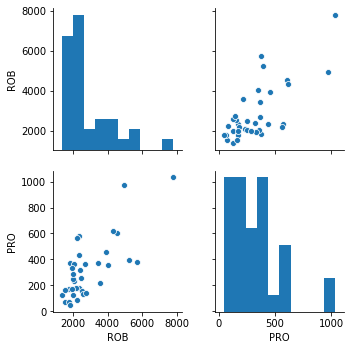

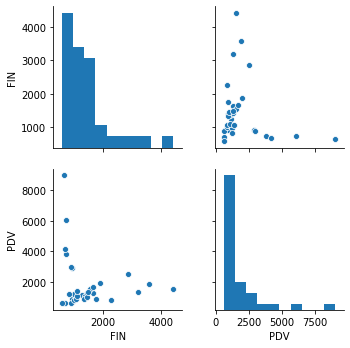

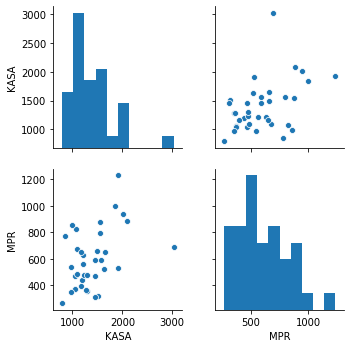

In [8]:
#Here we see some positive correlation between 'ROB' and 'PRO', and little less strong one between 'KASA' and 'MPR' modules.
import seaborn as sb
sb.pairplot(corrDF, vars=['ROB', 'PRO'])
sb.pairplot(corrDF, vars=['FIN', 'PDV'])
sb.pairplot(corrDF, vars=['KASA','MPR'])

In [9]:
#I decided to ignore slight correlation between 'FIN' and 'PDV' modules, and I will focus on correlation between pairs 'KASA-MPR'
#and 'PRO-ROB'. 


#I) "ROB-PRO" pair: Before doing ADF test on these series to check stationarity I checked if there's a trend in them by simply
#regressing these series to and ID column that I appended to corrDF. Purpose of this is to check wether or not to include trend
#in adfuller (this is done by setting default argument 'regression' of adfuller equal to 'ct' which stands for 'constant and trend')
#this is important because critical values of the test change depending on what is included in ADF regression. We see significance
#in both regressions and I will include trend in ADF test for 'ROB' and 'PRO' series. 

import statsmodels.api as smapi
ID = []
for i in range(1,37):
    ID.append(i)
corrDF['trend'] = ID


modelROB_trend = smapi.OLS(corrDF['ROB'], corrDF['trend']).fit()
print(modelROB_trend.summary())

modelPRO_trend = smapi.OLS(corrDF['PRO'], corrDF['trend']).fit()
print(modelPRO_trend.summary())

                                 OLS Regression Results                                
Dep. Variable:                    ROB   R-squared (uncentered):                   0.624
Model:                            OLS   Adj. R-squared (uncentered):              0.614
Method:                 Least Squares   F-statistic:                              58.20
Date:                Tue, 10 Dec 2019   Prob (F-statistic):                    6.00e-09
Time:                        23:10:15   Log-Likelihood:                         -323.61
No. Observations:                  36   AIC:                                      649.2
Df Residuals:                      35   BIC:                                      650.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [10]:
adfROB = adfuller(corrDF['ROB'],maxlag=1, regression='ct')
adfPRO = adfuller(corrDF['PRO'],maxlag=1, regression='ct')

In [11]:
#ADF test for 'PRO' modules are not stationary, so before I decide wether or not to include cointegration, I will run 2 more
#linear regression models, onde where 'ROB' is dependant variable and one where it's a regressor. I do this because I'm not 
#familiar with the business context of these series so I will run 2 regressions and try to conclude which of these two depend
#on which

print(adfROB)
print(adfPRO)

robY_proX = smapi.OLS(corrDF['ROB'], corrDF['PRO']).fit()
robX_proY = smapi.OLS(corrDF['PRO'], corrDF['ROB']).fit()

print(robX_proY.summary())
print(robY_proX.summary())



(-3.4863509480899557, 0.040874847574694985, 1, 34, {'1%': -4.253042608385915, '5%': -3.5485904579686545, '10%': -3.2070617952371263}, 575.7512061445851)
(-2.6635446157650953, 0.25152864277977105, 0, 35, {'1%': -4.243765510204081, '5%': -3.5443646122448977, '10%': -3.2046503498542274}, 453.3773792159383)
                                 OLS Regression Results                                
Dep. Variable:                    PRO   R-squared (uncentered):                   0.848
Model:                            OLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                              195.2
Date:                Tue, 10 Dec 2019   Prob (F-statistic):                    6.98e-16
Time:                        23:10:15   Log-Likelihood:                         -232.34
No. Observations:                  36   AIC:                                      466.7
Df Residuals:                      35   BIC:                                   

In [12]:
#Interestingly, these two regressions are pretty similar in terms of R squared and F-statistic for R square significance, but
#I will do cointegration with first one where the 'PRO' module is dependant variable, because of the smaller std. error of
#regression coefficient. Error metric on the test data will show if I this was right to do. 
#First I need predicted values:

robX_proY_predictions = robX_proY.predict()


#Now i will append this column on corrDF dataset for easier access:

corrDF['rob_pro'] = robX_proY_predictions
corrDF['spread'] = corrDF['ROB'] - 0.1147*corrDF['PRO']

#The column 'spread' represents linear combination od 'ROB' and 'PRO' series, which, if turns out to be stationary, indicates 
#cointegration between 'ROB' and 'PRO'. Now I will regress 'spread' on 'trend' to see if I'm to include trend in ADF regression


modelSPREAD_trend = smapi.OLS(corrDF['spread'], corrDF['trend']).fit()
#print(modelSPREAD_trend.summary())

#trend will be included in the ADF test for the spread because of the t value of 7.610.
cointROB_PRO = adfuller(corrDF['spread'], maxlag=10, regression= 'ct')
print(cointROB_PRO)

#Here I see that spread is not stationary, so no cointegration will be included in the model. I'll predict PRO and ROB with individual
#ARIMAs.



(-3.4575921499896527, 0.04415539631201066, 2, 33, {'1%': -4.262944107465843, '5%': -3.553092543339733, '10%': -3.2096284957008097}, 429.8233707884478)


In [13]:
#'KASA - MPR' pair: Trend also included in ADF test for both
modelKASA_trend = smapi.OLS(corrDF['KASA'], corrDF['trend']).fit()


modelMPR_trend = smapi.OLS(corrDF['MPR'], corrDF['trend']).fit()



In [14]:
adfKASA = adfuller(corrDF['KASA'],maxlag=10, regression='ct')
adfMPR = adfuller(corrDF['MPR'],maxlag=10, regression='ct')

In [15]:
print(adfKASA)
print(adfMPR)

#Here I'll take both of KASA and MPR series as stationary and I will model them directly with ARIMA

(-3.5880823240595996, 0.03086827030779107, 8, 27, {'1%': -4.339881664888482, '5%': -3.5877977071584612, '10%': -3.2293340725499164}, 365.9356686073637)
(-6.411288222886784, 2.8859287704180036e-07, 8, 27, {'1%': -4.339881664888482, '5%': -3.5877977071584612, '10%': -3.2293340725499164}, 333.3022006693802)


                                 Statespace Model Results                                 
Dep. Variable:                                  x   No. Observations:                   36
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -286.368
Date:                            Tue, 10 Dec 2019   AIC                            576.736
Time:                                    23:10:16   BIC                            579.846
Sample:                                01-31-2016   HQIC                           577.809
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.7538      0.100      7.554      0.000       0.558       0.949
sigma2       5.99e+05   1.55e+05   

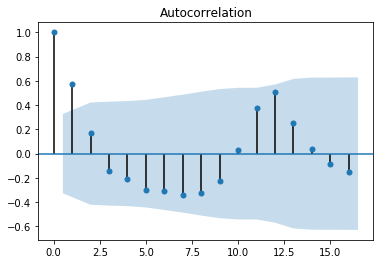

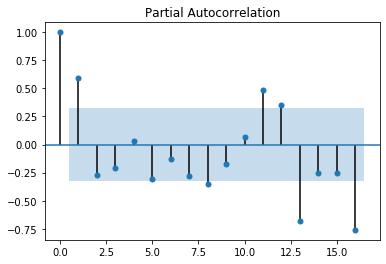

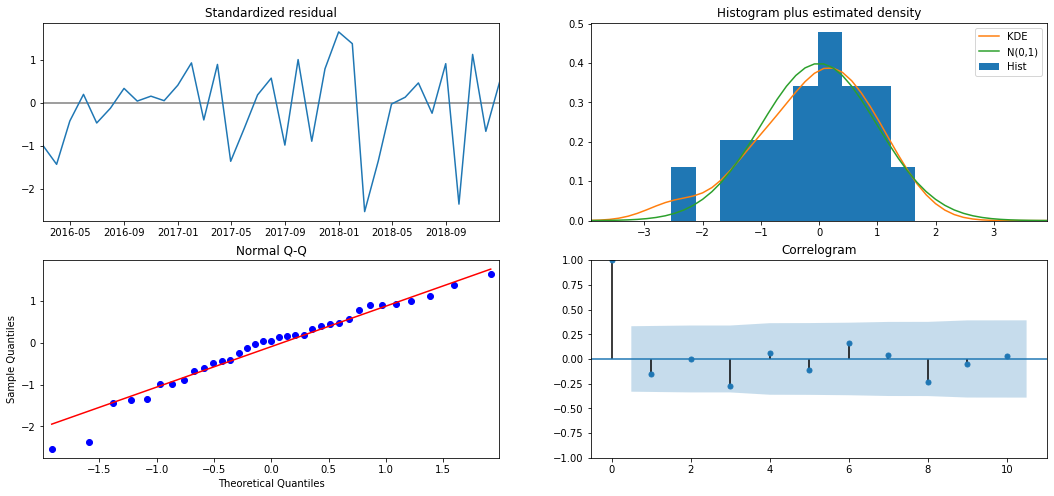

In [16]:
#ARIMA MODELING OF ALL 10 SERIES
#I will start with module 'ROB', because I know it has a unit root because of earlier cointegration test. I'll use the first
#difference of the series to get it to be stationary


#Here I fitted ARIMA model on 'ROB' module and it shows significant coefficient of seasonal AR parameter P=1. In diagnostic plots 
#I see that residuals are normal or very close to normal and that predictions fit the actual data pretty good, both on training 
# and test data. I made predictions for year 2020 and you can see it on the plot.

from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults, SARIMAXResultsWrapper

plot_acf(dfsDict_M_Train['ROB'])
plot_pacf(dfsDict_M_Train['ROB'])
robDiff = dfsDict_M_Train['ROB'].diff(1)
robARIMA = SARIMAX(dfsDict_M_Train['ROB'], order=(0,1,0), seasonal_order=(1,0,0,12)).fit(disp=0)
robARIMA1 = SARIMAX(robDiff.iloc[1:], order=(0,0,0), seasonal_order=(1,0,0,12)).fit(disp=0)
print(robARIMA.summary())
print(robARIMA1.summary())
robARIMA.plot_diagnostics(figsize=(18, 8))
plt.show()
robPREDICTIONS = robARIMA.predict()
robFORECAST = robARIMA.forecast(steps=24)




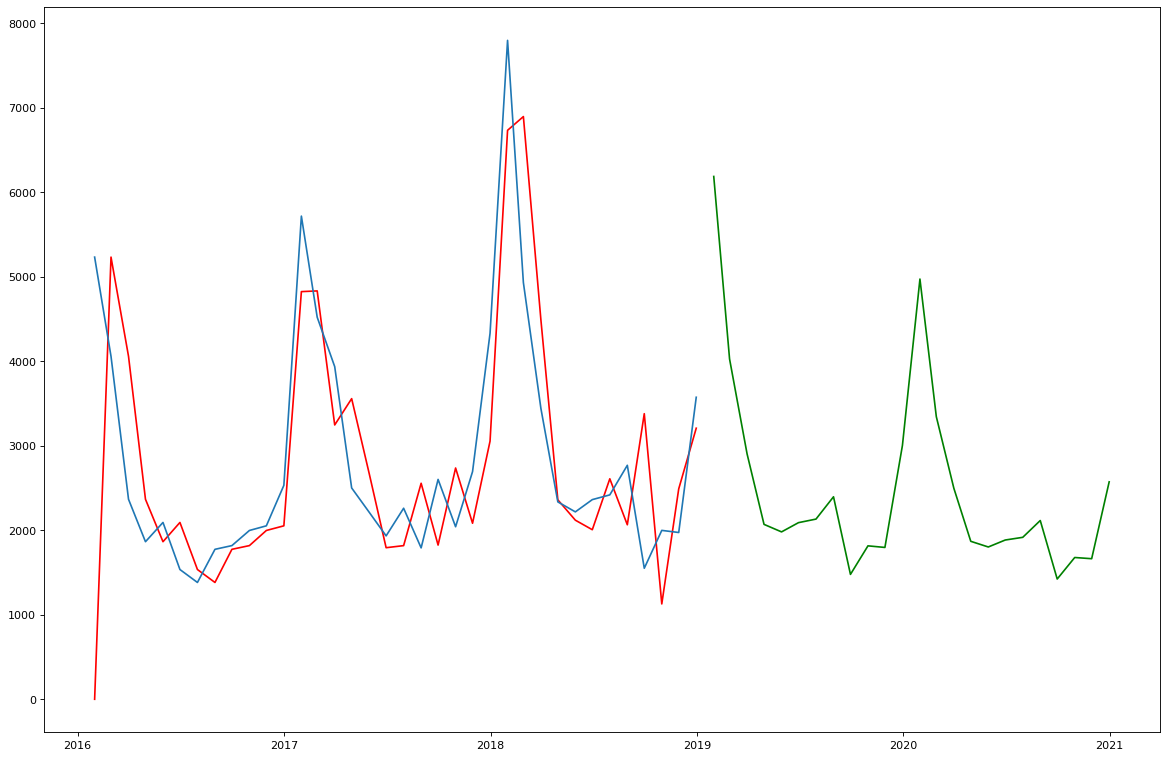

<Figure size 1296x864 with 0 Axes>

In [17]:

figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(robPREDICTIONS,color = 'r')
plt.plot(robFORECAST,color = 'g')
plt.plot(dfsDict_M_Train['ROB'])

plt.figure(figsize=(18,12))


# I alse saved MSEs for both training and test and they do not indicate overfitting.

MSE_Training = mean_squared_error(dfsDict_M_Train['ROB'].x, robPREDICTIONS)
MSE_Test = mean_squared_error(dfsDict_M_Test['ROB'].x, robFORECAST[0:10])

In [18]:
print(MSE_Training, MSE_Test)

1402747.11374008 374256.19908536936


[3,             TEHNICKA
 datum               
 2016-04-30    -250.0
 2016-05-31    -518.0
 2016-06-30       6.0
 2016-07-31    -131.0
 2016-08-31    -157.0
 2016-09-30    -237.0
 2016-10-31       5.0
 2016-11-30     -43.0
 2016-12-31     365.0
 2017-01-31     317.0
 2017-02-28    -175.0
 2017-03-31    -143.0
 2017-04-30    -553.0
 2017-05-31     180.0
 2017-06-30     219.0
 2017-07-31     400.0
 2017-08-31     350.0
 2017-09-30    -322.0
 2017-10-31     -51.0
 2017-11-30     -22.0
 2017-12-31    1148.0
 2018-01-31     328.0
 2018-02-28    -358.0
 2018-03-31   -1128.0
 2018-04-30    -565.0
 2018-05-31     230.0
 2018-06-30     121.0
 2018-07-31     313.0
 2018-08-31    -199.0
 2018-09-30    -114.0
 2018-10-31     -45.0
 2018-11-30     397.0
 2018-12-31      70.0, <Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>]

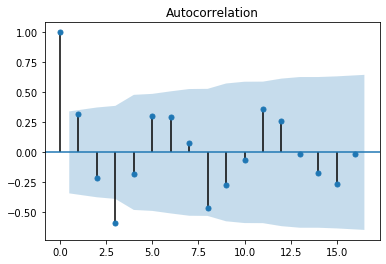

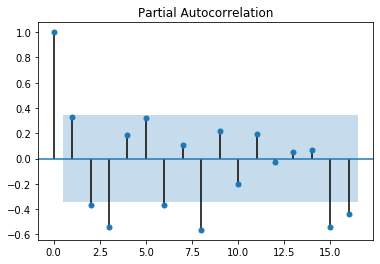

In [19]:
#Modeling 'ROB' module made me write two functions for purpose of automating ARIMA fitting: seriesDifference and arimaDiag
#- I explain those in comments below.

from scipy.stats import pearsonr

#Function seriesDifference creates time series difference for a given order of differencing. I didn't use .diff() method
#because it doesn't accept 0 as an argument. For my purposes, I consider 0th difference to be the series itself.

def seriesDifference(series, order):
    if order == 0:
        return series
    else:
        return series.diff(order)
#Function arimaDiag(seg as string) returns a list with following elements:
#  integrationOrder - integer, order of difference neccesary for stationarity
#  integratedSeries - time series differenced with order integrationOrder
#  acfPlot - autocorrelation function of integratedSeries
#  pacfPlot - partial autocorrelation function of integratedSeries

#This function is a result of me trying to automate the process of fitting ARIMAs from this point on as much as I possibly can,
#but automating it entirely turned out to be impossible without using auto_arima, but I didn't want to use that one for various
#reasons.

def arimaDiag(seg):
    integrationOrder = 0
    series = corrDF[seg]
    trend = corrDF['trend'] 
    trendCheck = smapi.OLS(series, trend).fit()
    for i in range(0,4):
        if float(trendCheck.pvalues) <0.05:
            adfTest = adfuller(seriesDifference(series,i).iloc[integrationOrder:], maxlag = 10, regression = 'ct')
        else:
            adfTest = adfuller(seriesDifference(series,i).iloc[integrationOrder:], maxlag = 10, regression= 'c')
            
        if adfTest[0] > adfTest[4]['5%']:
                break
        else:
            integrationOrder += 1
    integratedSeries = pd.DataFrame(seriesDifference(series, integrationOrder)).iloc[integrationOrder:].set_index(dfsDict_M_Train[seg].iloc[integrationOrder:].index)
    acfPlot = plot_acf(integratedSeries)
    pacfPlot = plot_pacf(integratedSeries)
    
    return [integrationOrder, integratedSeries, acfPlot, pacfPlot]
#I call arimaSeg on module 'Tehnicka' and then I model time series similarly as above. From each module I will do a following procedure:
#1  arimaSeg()
#2  __moduleName__ARIMA = SARIMAX(.....)
#3  print model summary and plot model diagnostics
#4  calculate PREDICTIONS and FORECAST
#5  plot both from 5
#6  comment on it

arimaDiag('TEHNICKA')
    
   

D:\Python_Sve\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                           Statespace Model Results                           
Dep. Variable:                      x   No. Observations:                   36
Model:               SARIMAX(0, 3, 3)   Log Likelihood                -241.291
Date:                Tue, 10 Dec 2019   AIC                            490.583
Time:                        23:10:19   BIC                            496.569
Sample:                    01-31-2016   HQIC                           492.597
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.6482      0.258    -10.249      0.000      -3.155      -2.142
ma.L2          2.2980      0.492      4.669      0.000       1.333       3.263
ma.L3         -0.6498      0.259     -2.505      0.0

<Figure size 1440x720 with 0 Axes>

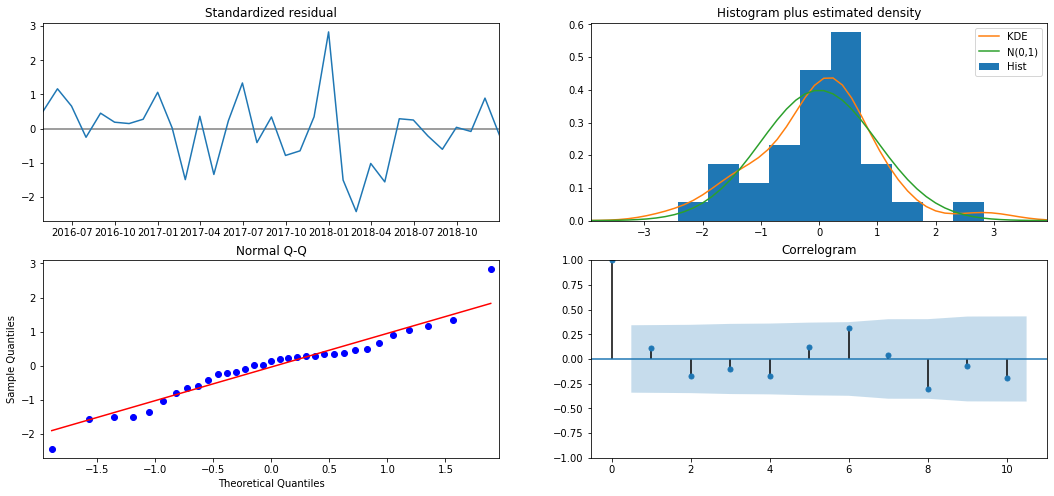

In [20]:
plt.figure(figsize=(20,10))
tehnickaARIMA = SARIMAX(dfsDict_M_Train['TEHNICKA'], order=(0,3,3), seasonal_order=(0,0,0,0)).fit(disp = 0)
print(tehnickaARIMA.summary())
tehnickaARIMA.plot_diagnostics(figsize=(18, 8))
tehnickaPREDICTIONS = tehnickaARIMA.predict()
tehnickaFORECAST = tehnickaARIMA.forecast(steps=24)

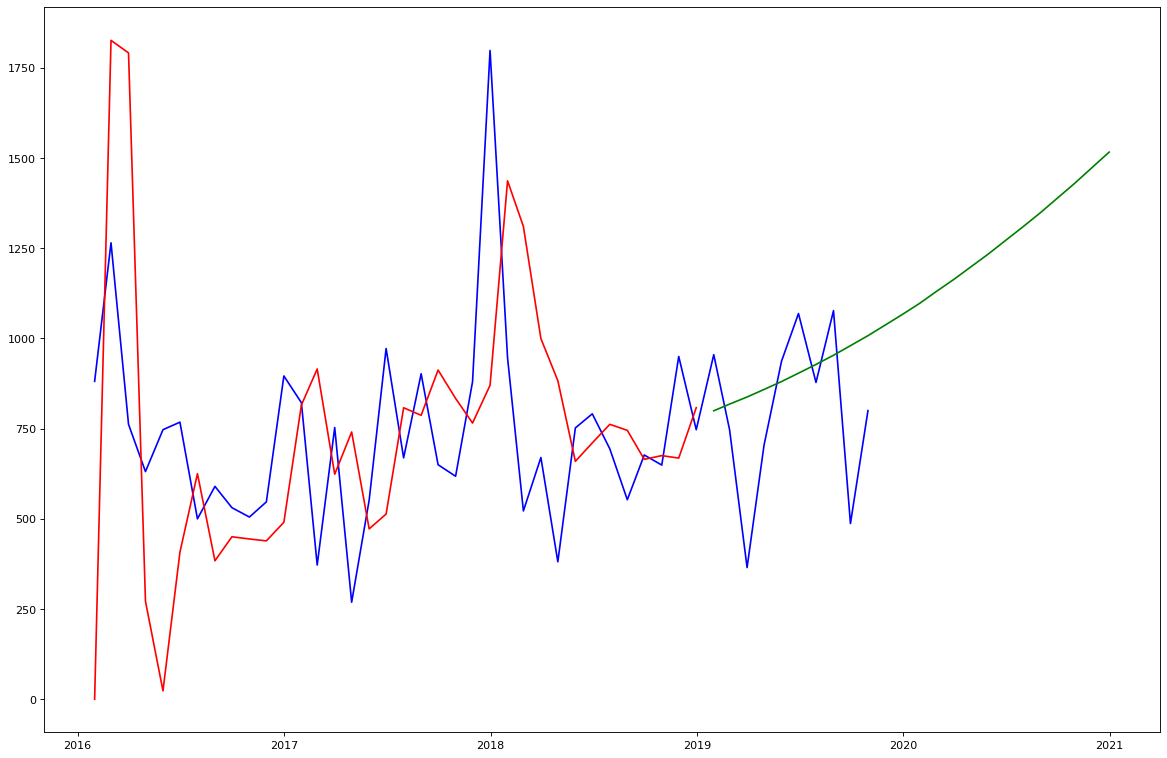

In [21]:
figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
actual =plt.plot(dfsDict_M_TrainTest['TEHNICKA'].x,color = 'b')
fitted = plt.plot(tehnickaPREDICTIONS, color = 'r')
forecasted = plt.plot(tehnickaFORECAST,color = 'g')




In [22]:
print(mean_squared_error(dfsDict_M_Train['TEHNICKA'].x, tehnickaPREDICTIONS))
print(mean_squared_error(dfsDict_M_Test['TEHNICKA'].x,tehnickaFORECAST[0:10]))

175383.758185682
61102.12716212714


[0,             FAKT
 datum           
 2016-01-31  1579
 2016-02-29  1026
 2016-03-31  1363
 2016-04-30  1158
 2016-05-31  1360
 2016-06-30   839
 2016-07-31   711
 2016-08-31  1156
 2016-09-30  1153
 2016-10-31   994
 2016-11-30  1424
 2016-12-31  1131
 2017-01-31  1399
 2017-02-28  1202
 2017-03-31  1640
 2017-04-30  1228
 2017-05-31  1439
 2017-06-30  1110
 2017-07-31  1070
 2017-08-31  1150
 2017-09-30   957
 2017-10-31  1555
 2017-11-30  1692
 2017-12-31  1383
 2018-01-31  2133
 2018-02-28   906
 2018-03-31  2613
 2018-04-30  1125
 2018-05-31  1290
 2018-06-30  1020
 2018-07-31  1119
 2018-08-31  1489
 2018-09-30  1304
 2018-10-31  1140
 2018-11-30  1220
 2018-12-31  1283, <Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>]

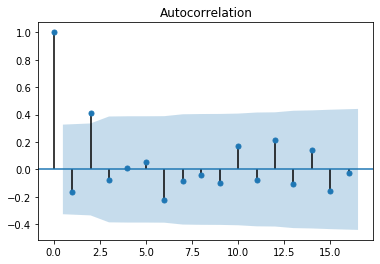

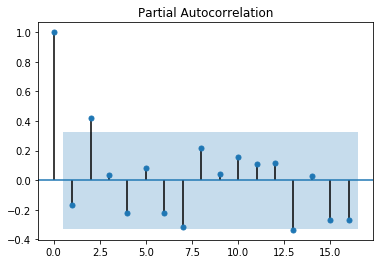

In [23]:
arimaDiag('FAKT')

                           Statespace Model Results                           
Dep. Variable:                      x   No. Observations:                   36
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -263.854
Date:                Tue, 10 Dec 2019   AIC                            533.708
Time:                        23:10:22   BIC                            538.458
Sample:                    01-31-2016   HQIC                           535.366
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2480      0.086      2.873      0.004       0.079       0.417
ar.L2          0.7310      0.069     10.654      0.000       0.597       0.865
sigma2      1.233e+05   2.76e+04      4.470      0.0

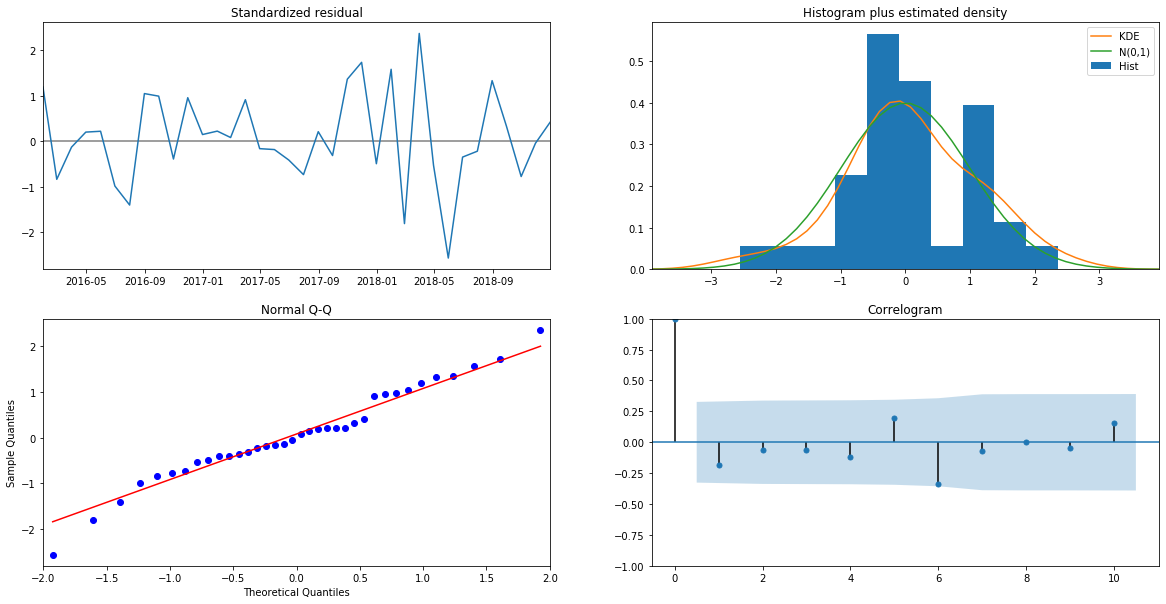

In [24]:
faktARIMA = SARIMAX(dfsDict_M_Train['FAKT'], order=(2,0,0), seasonal_order=(0,0,0,0)).fit(disp=0)
print(faktARIMA.summary())
faktARIMA.plot_diagnostics(figsize=(20,10))

plt.show()

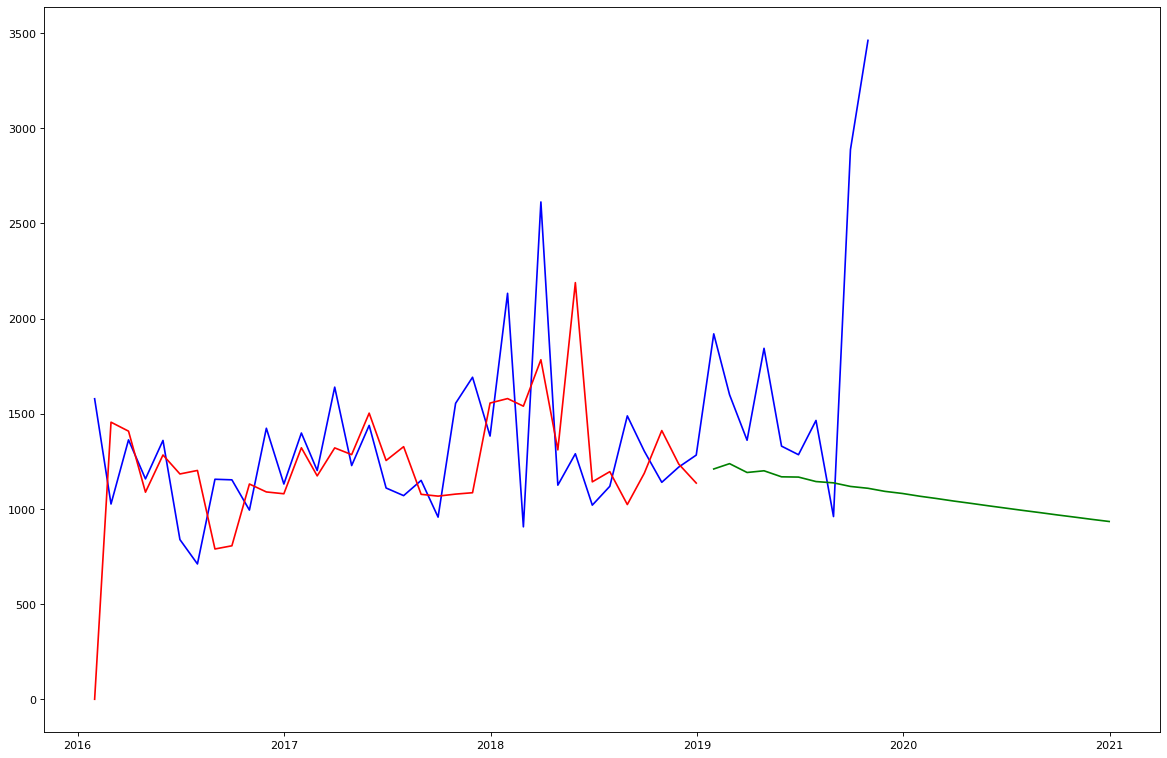

In [25]:
figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
faktPREDICTIONS = faktARIMA.predict()
faktFORECAST = faktARIMA.forecast(steps=24)

plt.plot(dfsDict_M_TrainTest['FAKT'].x, color = 'b')
plt.plot(faktPREDICTIONS, color = 'r')
plt.plot(faktFORECAST, color = 'g')
plt.legend = (('actual', 'fitted', 'residual'))
plt.show()

In [26]:
print('MSE TRAINING: ', mean_squared_error(dfsDict_M_Train['FAKT'].x, faktPREDICTIONS))
print('MSE TEST: ',  mean_squared_error(dfsDict_M_Test['FAKT'].x, faktFORECAST[0:10]))

MSE TRAINING:  190850.32943358092
MSE TEST:  992264.6089587423


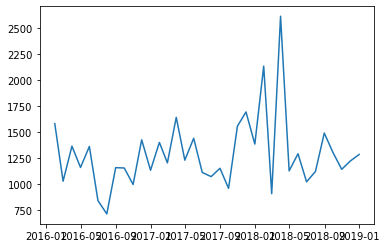

In [27]:
plt.plot(dfsDict_M_Train['FAKT'])

[4,                FIN
 datum             
 2016-05-31  -518.0
 2016-06-30 -3090.0
 2016-07-31  -691.0
 2016-08-31  -346.0
 2016-09-30  -792.0
 2016-10-31  -430.0
 2016-11-30   197.0
 2016-12-31   101.0
 2017-01-31  1067.0
 2017-02-28  2299.0
 2017-03-31  1375.0
 2017-04-30    22.0
 2017-05-31  -586.0
 2017-06-30 -1439.0
 2017-07-31 -1215.0
 2017-08-31   -53.0
 2017-09-30  -235.0
 2017-10-31  -667.0
 2017-11-30    29.0
 2017-12-31   558.0
 2018-01-31  2025.0
 2018-02-28  2479.0
 2018-03-31   581.0
 2018-04-30  -100.0
 2018-05-31 -1394.0
 2018-06-30 -2102.0
 2018-07-31  -935.0
 2018-08-31  -780.0
 2018-09-30  -729.0
 2018-10-31  -792.0
 2018-11-30   180.0
 2018-12-31   236.0, <Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>]

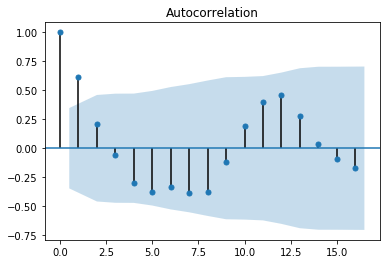

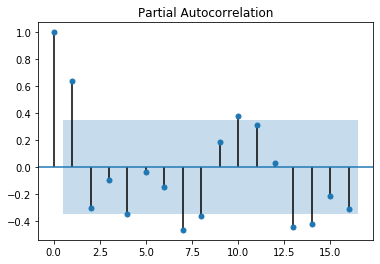

In [28]:
arimaDiag('FIN')

In [29]:
adfuller(dfsDict_M_Train['FIN'].x, maxlag=10, regression = 'ct')


(-4.367326876014731,
 0.0024676205261352693,
 1,
 34,
 {'1%': -4.253042608385915,
  '5%': -3.5485904579686545,
  '10%': -3.2070617952371263},
 396.784454883875)

                                 Statespace Model Results                                
Dep. Variable:                                 x   No. Observations:                   36
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 6)   Log Likelihood                -227.486
Date:                           Tue, 10 Dec 2019   AIC                            460.972
Time:                                   23:10:26   BIC                            465.074
Sample:                               01-31-2016   HQIC                           462.257
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3927      0.202     -1.946      0.052      -0.788       0.003
ar.S.L6       -0.9066      0.077    -11.757

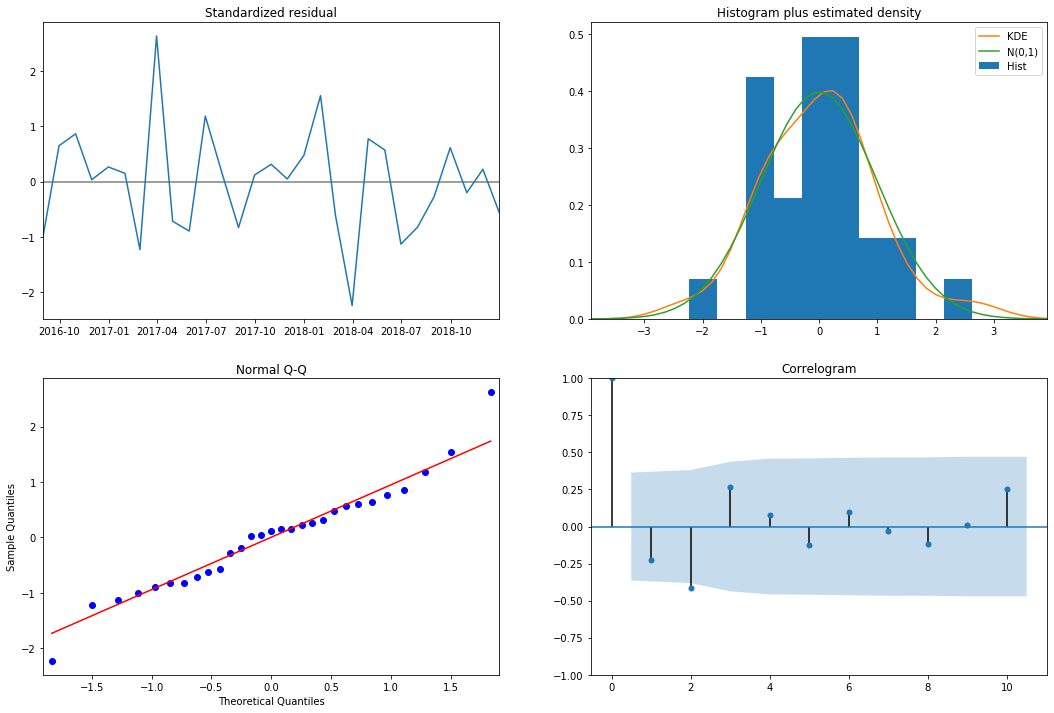

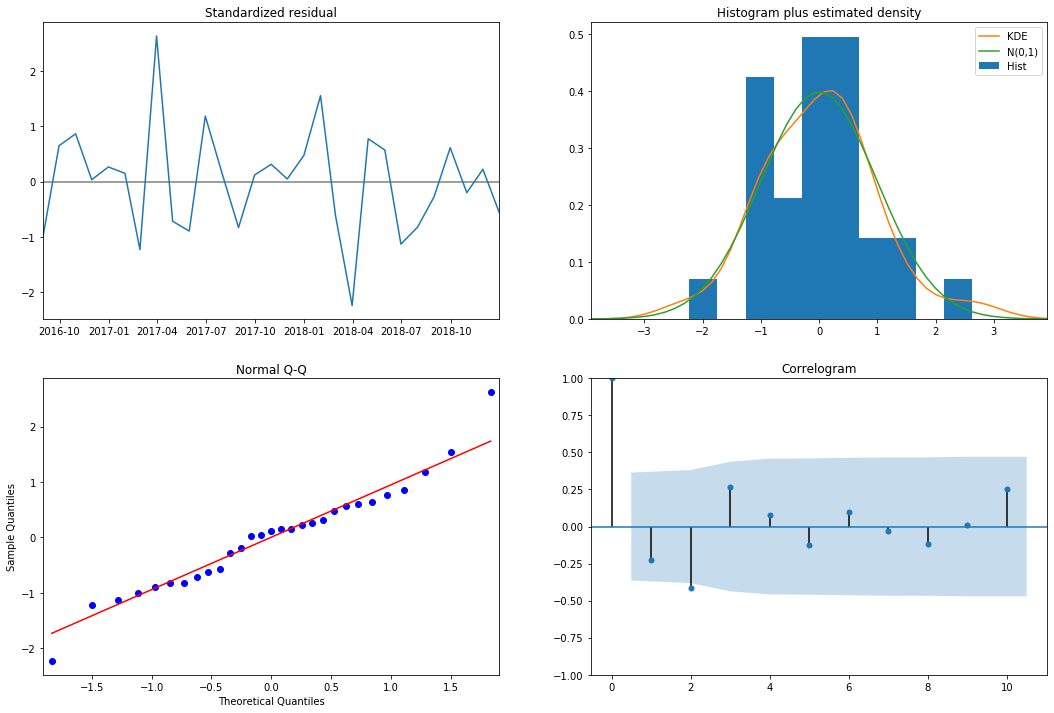

In [30]:
finARIMA = SARIMAX(dfsDict_M_Train['FIN'], order=(1,1,0),seasonal_order=(1,1,0,6)).fit(disp=0)
print(finARIMA.summary())
finPREDICTIONS = finARIMA.predict()
finFORECAST = finARIMA.forecast(steps = 24)
finARIMA.plot_diagnostics(figsize=(18,12))

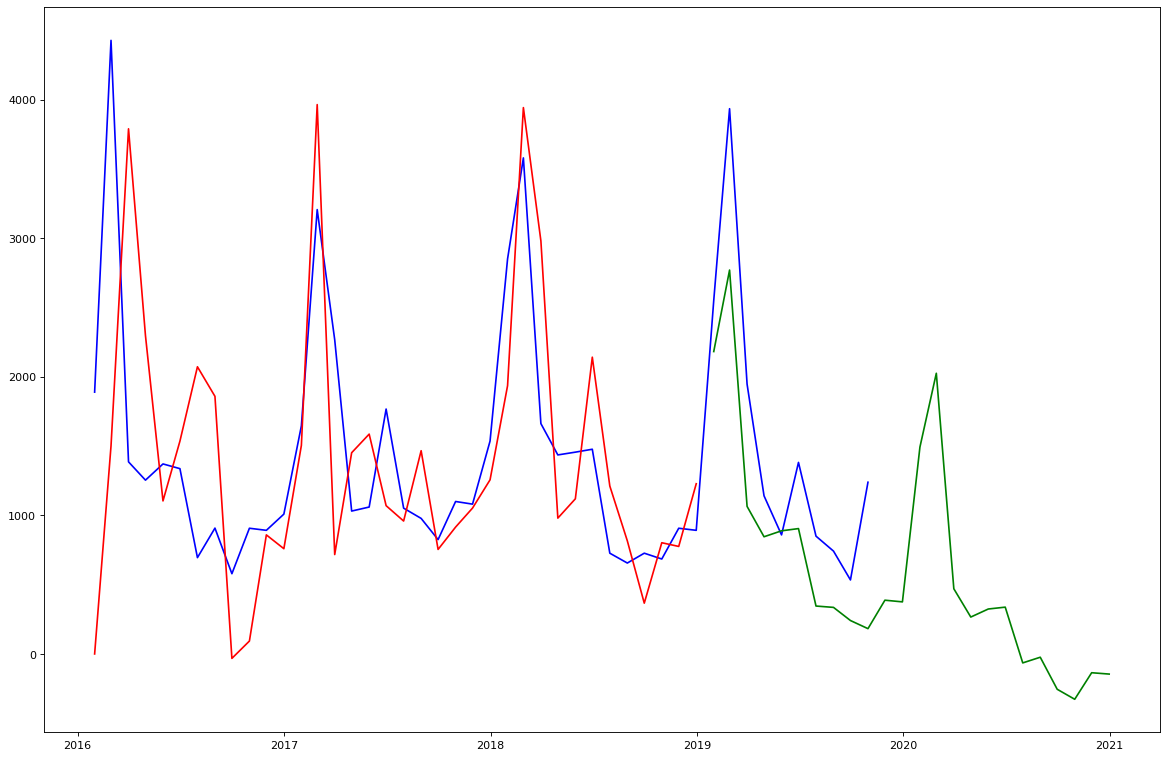

In [31]:
figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfsDict_M_TrainTest['FIN'].x, color = 'b')
plt.plot(finPREDICTIONS, color = 'r')
plt.plot(finFORECAST, color = 'g')


plt.show()

In [32]:
print('MSE Training: ', mean_squared_error(dfsDict_M_Train['FIN'].x, finPREDICTIONS))
print('MSE Test: ', mean_squared_error(dfsDict_M_Test['FIN'].x, finFORECAST[0:10]))

MSE Training:  869661.027981698
MSE Test:  420702.3744890321


D:\Python_Sve\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


[4,               KASA
 datum             
 2016-05-31  -178.0
 2016-06-30  -588.0
 2016-07-31  -752.0
 2016-08-31   -22.0
 2016-09-30  -349.0
 2016-10-31   -13.0
 2016-11-30   665.0
 2016-12-31   441.0
 2017-01-31  1461.0
 2017-02-28   976.0
 2017-03-31   464.0
 2017-04-30  -532.0
 2017-05-31 -1832.0
 2017-06-30 -1048.0
 2017-07-31  -630.0
 2017-08-31   186.0
 2017-09-30    23.0
 2017-10-31  -115.0
 2017-11-30   -67.0
 2017-12-31   467.0
 2018-01-31   630.0
 2018-02-28   605.0
 2018-03-31  -236.0
 2018-04-30  -332.0
 2018-05-31  -636.0
 2018-06-30  -415.0
 2018-07-31   288.0
 2018-08-31   200.0
 2018-09-30  -112.0
 2018-10-31   411.0
 2018-11-30  -112.0
 2018-12-31    56.0, <Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>]

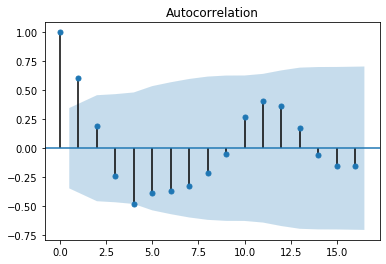

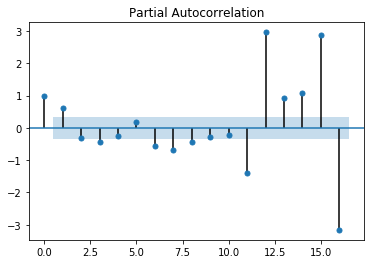

In [33]:
arimaDiag('KASA')

                                 Statespace Model Results                                
Dep. Variable:                                 x   No. Observations:                   36
Model:             SARIMAX(2, 3, 0)x(0, 1, 0, 4)   Log Likelihood                -236.625
Date:                           Tue, 10 Dec 2019   AIC                            479.251
Time:                                   23:10:30   BIC                            483.352
Sample:                               01-31-2016   HQIC                           480.535
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0466      0.230     -4.542      0.000      -1.498      -0.595
ar.L2         -0.4963      0.162     -3.069

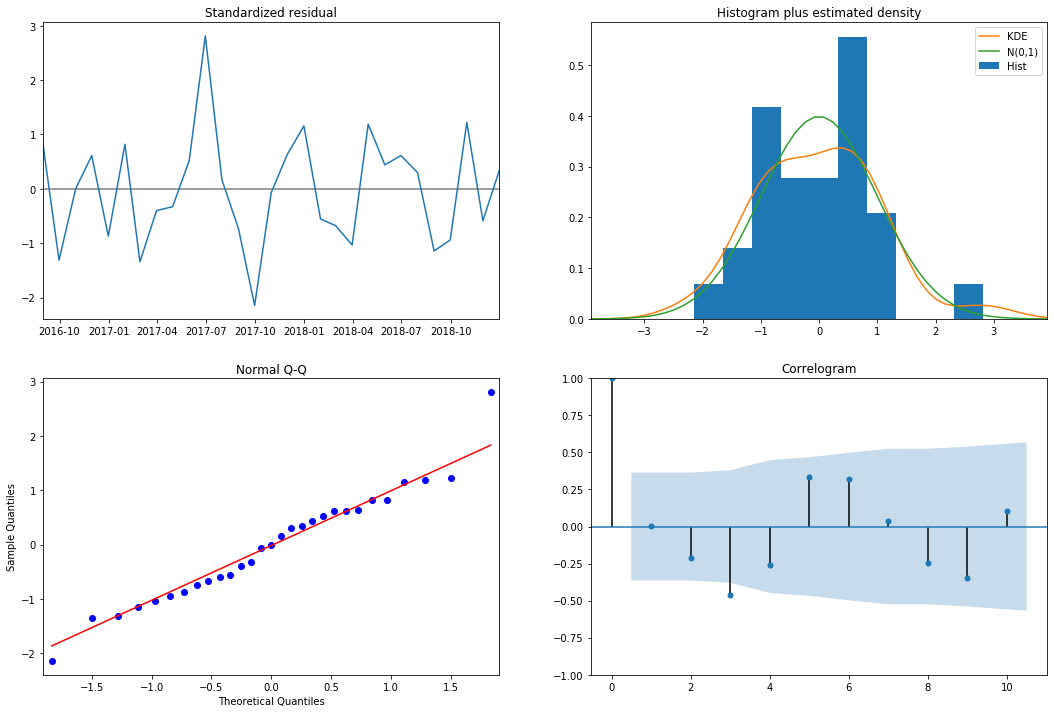

In [34]:
kasaARIMA = SARIMAX(dfsDict_M_Train['KASA'], order=(2,3,0), seasonal_order=(0,1,0,4)).fit(disp = 0)
print(kasaARIMA.summary())
kasaARIMA.plot_diagnostics(figsize = (18,12))
kasaPREDICTIONS = kasaARIMA.predict()
kasaFORECAST = kasaARIMA.forecast(steps = 24)


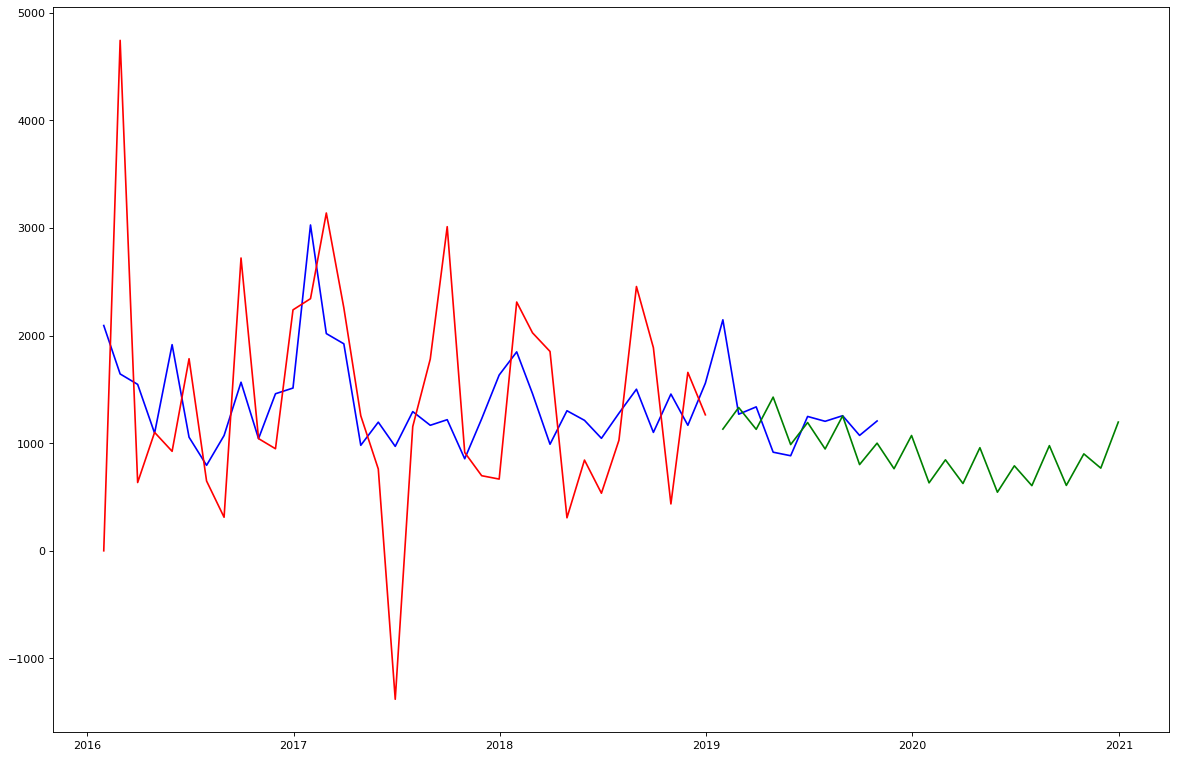

In [35]:
figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfsDict_M_TrainTest['KASA'].x, color = 'b')
plt.plot(kasaPREDICTIONS, color = 'r')
plt.plot(kasaFORECAST, color= 'g')
plt.show()



In [36]:
print('MSE Training: ', mean_squared_error(dfsDict_M_Train['KASA'].x, kasaPREDICTIONS))
print('MSE Test: ', mean_squared_error(dfsDict_M_Test['KASA'].x, kasaFORECAST[0:10]))

MSE Training:  1031254.9255234862
MSE Test:  153655.51068443136


D:\Python_Sve\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


[2,               MPR
 datum            
 2016-03-31  -10.0
 2016-04-30   18.0
 2016-05-31 -346.0
 2016-06-30 -300.0
 2016-07-31 -265.0
 2016-08-31  450.0
 2016-09-30  327.0
 2016-10-31 -450.0
 2016-11-30 -121.0
 2016-12-31  -51.0
 2017-01-31  221.0
 2017-02-28  619.0
 2017-03-31  543.0
 2017-04-30 -399.0
 2017-05-31 -791.0
 2017-06-30 -192.0
 2017-07-31  -89.0
 2017-08-31   43.0
 2017-09-30  206.0
 2017-10-31  383.0
 2017-11-30  -85.0
 2017-12-31 -255.0
 2018-01-31  526.0
 2018-02-28   67.0
 2018-03-31 -147.0
 2018-04-30 -111.0
 2018-05-31 -221.0
 2018-06-30   -9.0
 2018-07-31 -269.0
 2018-08-31  189.0
 2018-09-30  123.0
 2018-10-31 -347.0
 2018-11-30  166.0
 2018-12-31  485.0, <Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>]

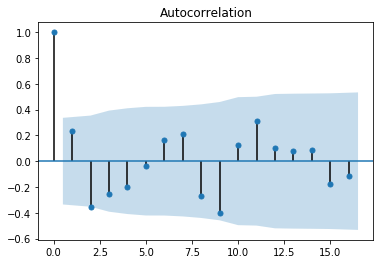

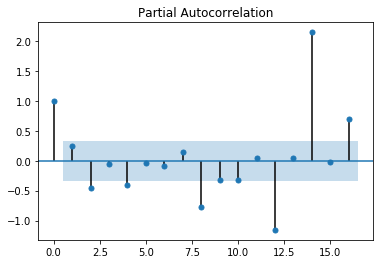

In [37]:
arimaDiag('MPR')

                            Statespace Model Results                            
Dep. Variable:                        x   No. Observations:                   36
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -166.472
Date:                  Tue, 10 Dec 2019   AIC                            334.943
Time:                          23:10:33   BIC                            336.121
Sample:                      01-31-2016   HQIC                           335.256
                           - 12-31-2018                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.197e+04   2.42e+04      2.562      0.010    1.46e+04    1.09e+05
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 1.28
Prob(Q):                       

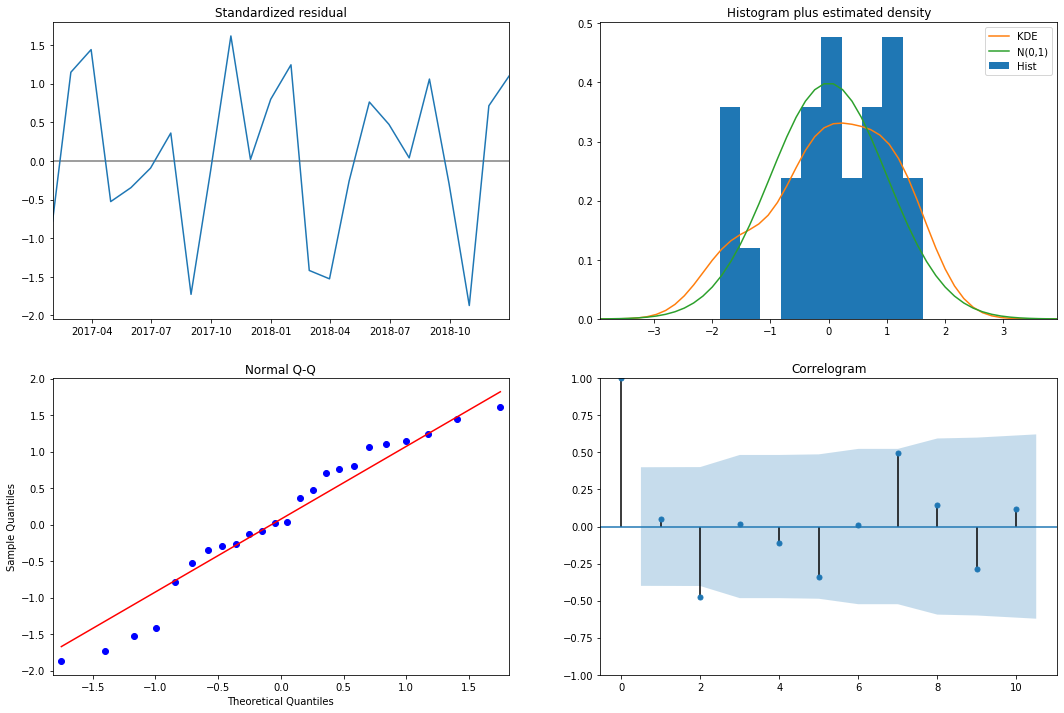

In [38]:
mprARIMA = SARIMAX(dfsDict_M_Train['MPR'], order = (0,0,0), seasonal_order=(0,1,0,12)).fit(disp=0)
print(mprARIMA.summary())
mprARIMA.plot_diagnostics(figsize = (18,12))
mprPREDICTIONS = mprARIMA.predict()
mprFORECAST = mprARIMA.forecast(steps = 24)


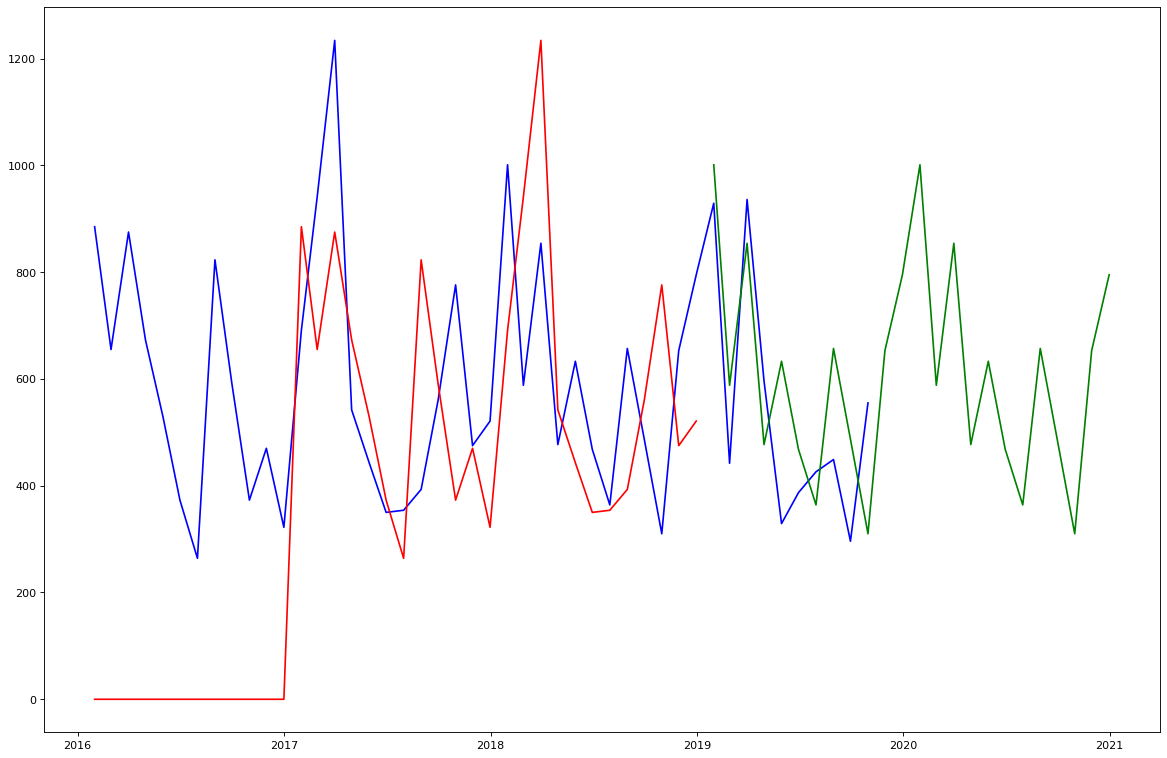

In [39]:
figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfsDict_M_TrainTest['MPR'].x, color = 'b')
plt.plot(mprPREDICTIONS, color = 'r')
plt.plot(mprFORECAST, color = 'g')



In [40]:
print('MSE Training: ', mean_squared_error(dfsDict_M_Train['MPR'].x, mprPREDICTIONS))
print('MSE Test: ', mean_squared_error(dfsDict_M_Test['MPR'].x, mprFORECAST[0:10]))

MSE Training:  163821.86111111112
MSE Test:  28997.599999999995


[0,              OBR
 datum           
 2016-01-31  4831
 2016-02-29  5062
 2016-03-31  4556
 2016-04-30  5142
 2016-05-31  2946
 2016-06-30  2723
 2016-07-31  2956
 2016-08-31  2558
 2016-09-30  2654
 2016-10-31  2995
 2016-11-30  3394
 2016-12-31  3970
 2017-01-31  5234
 2017-02-28  5078
 2017-03-31  4569
 2017-04-30  4239
 2017-05-31  3100
 2017-06-30  3100
 2017-07-31  3528
 2017-08-31  4118
 2017-09-30  4332
 2017-10-31  4160
 2017-11-30  4044
 2017-12-31  4594
 2018-01-31  6870
 2018-02-28  5561
 2018-03-31  4965
 2018-04-30  4865
 2018-05-31  3909
 2018-06-30  3401
 2018-07-31  2883
 2018-08-31  3393
 2018-09-30  3480
 2018-10-31  3445
 2018-11-30  4004
 2018-12-31  4654, <Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>]

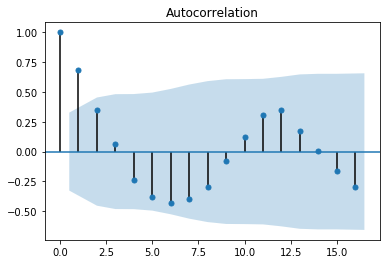

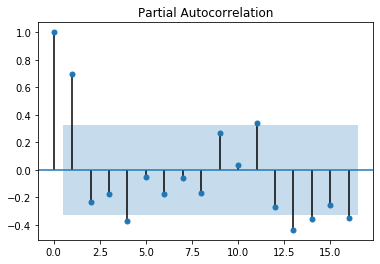

In [41]:
arimaDiag('OBR')

[0,              OBR
 datum           
 2016-01-31  4831
 2016-02-29  5062
 2016-03-31  4556
 2016-04-30  5142
 2016-05-31  2946
 2016-06-30  2723
 2016-07-31  2956
 2016-08-31  2558
 2016-09-30  2654
 2016-10-31  2995
 2016-11-30  3394
 2016-12-31  3970
 2017-01-31  5234
 2017-02-28  5078
 2017-03-31  4569
 2017-04-30  4239
 2017-05-31  3100
 2017-06-30  3100
 2017-07-31  3528
 2017-08-31  4118
 2017-09-30  4332
 2017-10-31  4160
 2017-11-30  4044
 2017-12-31  4594
 2018-01-31  6870
 2018-02-28  5561
 2018-03-31  4965
 2018-04-30  4865
 2018-05-31  3909
 2018-06-30  3401
 2018-07-31  2883
 2018-08-31  3393
 2018-09-30  3480
 2018-10-31  3445
 2018-11-30  4004
 2018-12-31  4654, <Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>]

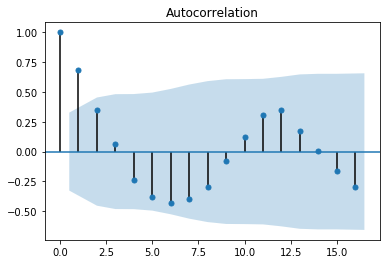

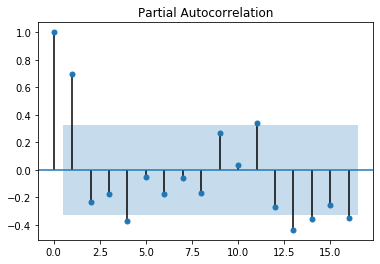

In [42]:
arimaDiag('OBR')

                                 Statespace Model Results                                
Dep. Variable:                                 x   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 6)   Log Likelihood                -235.517
Date:                           Tue, 10 Dec 2019   AIC                            477.034
Time:                                   23:10:36   BIC                            481.237
Sample:                               01-31-2016   HQIC                           478.379
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7683      0.090      8.556      0.000       0.592       0.944
ar.S.L6       -0.8406      0.078    -10.742

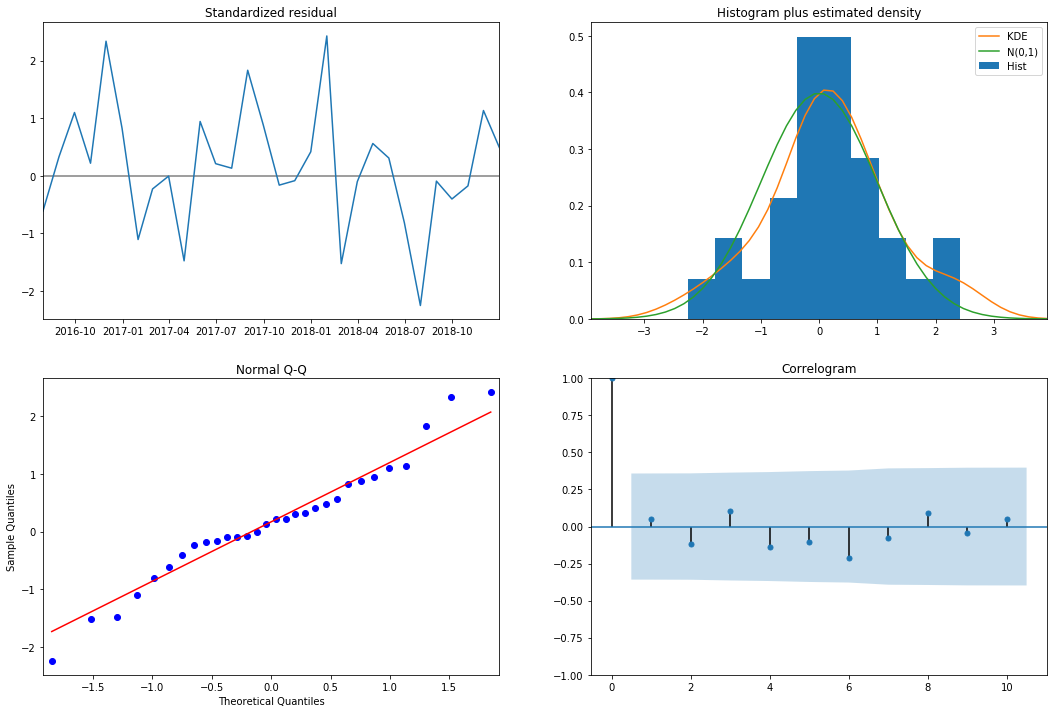

In [43]:
obrARIMA = SARIMAX(dfsDict_M_Train['OBR'], order = (1,0,0), seasonal_order=(1,1,0,6)).fit(disp=0)
print(obrARIMA.summary())
obrARIMA.plot_diagnostics(figsize = (18,12))
obrPREDICTIONS = obrARIMA.predict()
obrFORECAST = obrARIMA.forecast(steps = 24)

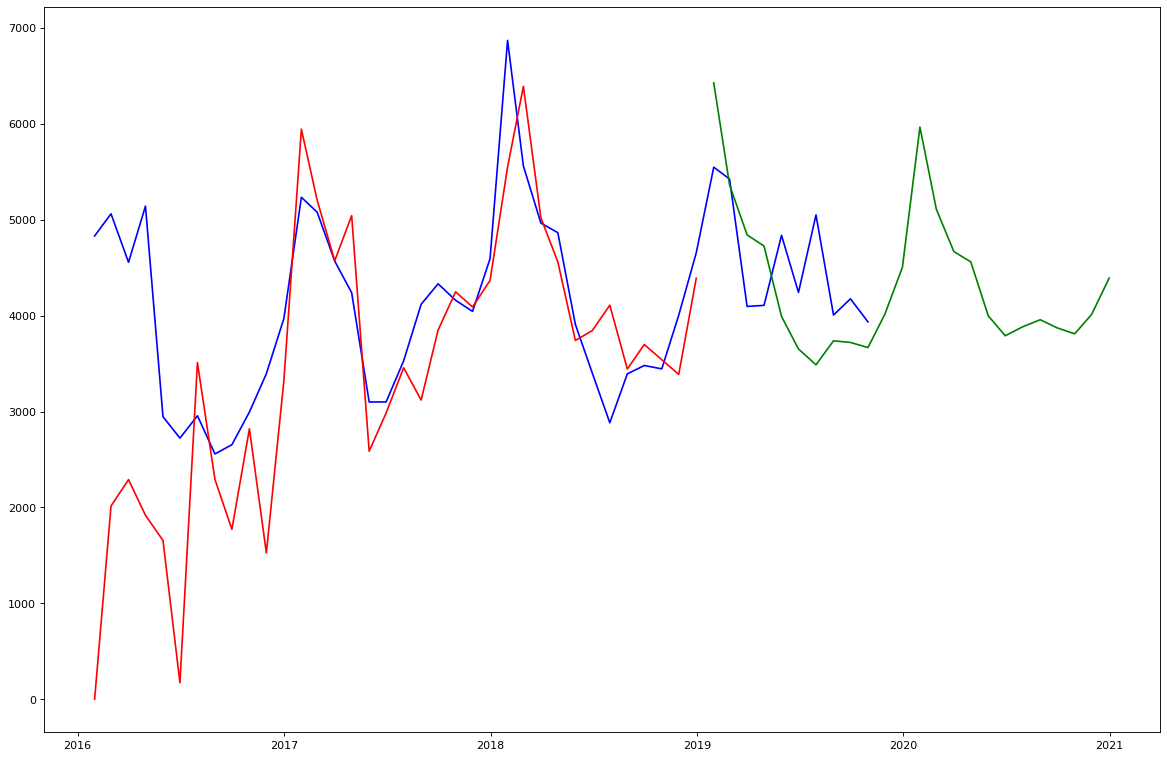

In [44]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')

plt.plot(dfsDict_M_TrainTest['OBR'].x, color = 'b')
plt.plot(obrPREDICTIONS, color = 'r')
plt.plot(obrFORECAST, color = 'g')
plt.legend = (('actual', 'fitted', 'forecasted'))
plt.show()


In [45]:
print('MSE Training: ', mean_squared_error(dfsDict_M_Train['OBR'].x, obrPREDICTIONS))
print('MSE Test :', mean_squared_error(dfsDict_M_Test['OBR'].x, obrFORECAST[0:10]))

MSE Training:  1914458.1265858023
MSE Test : 557154.4331674025


[2,                 OS
 datum             
 2016-03-31  -163.0
 2016-04-30 -2040.0
 2016-05-31  -578.0
 2016-06-30    32.0
 2016-07-31   -84.0
 2016-08-31  -280.0
 2016-09-30    97.0
 2016-10-31   138.0
 2016-11-30   -88.0
 2016-12-31    71.0
 2017-01-31  1129.0
 2017-02-28  1869.0
 2017-03-31  -466.0
 2017-04-30 -1680.0
 2017-05-31  -404.0
 2017-06-30   201.0
 2017-07-31  -162.0
 2017-08-31  -253.0
 2017-09-30   320.0
 2017-10-31     6.0
 2017-11-30  -111.0
 2017-12-31   479.0
 2018-01-31  1403.0
 2018-02-28  1079.0
 2018-03-31  -673.0
 2018-04-30 -1455.0
 2018-05-31  -784.0
 2018-06-30   108.0
 2018-07-31   -59.0
 2018-08-31  -334.0
 2018-09-30   145.0
 2018-10-31     7.0
 2018-11-30   -20.0
 2018-12-31   498.0, <Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>]

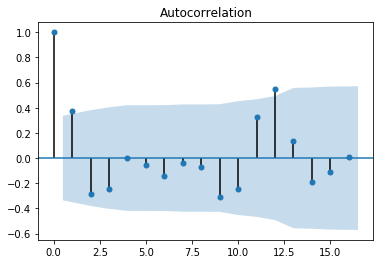

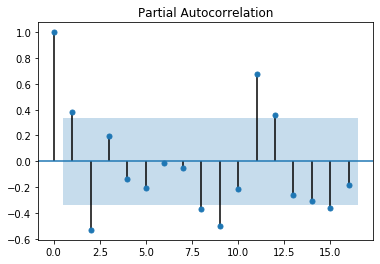

In [46]:
arimaDiag('OS')

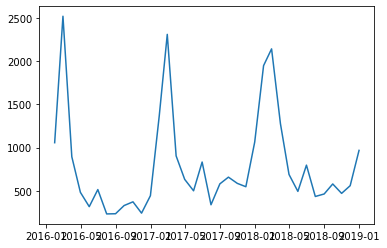

In [47]:
plt.plot(dfsDict_M_Train['OS']) 

                                 Statespace Model Results                                 
Dep. Variable:                                  x   No. Observations:                   36
Model:             SARIMAX(0, 2, 2)x(0, 1, 0, 12)   Log Likelihood                -152.271
Date:                            Tue, 10 Dec 2019   AIC                            310.541
Time:                                    23:10:39   BIC                            313.814
Sample:                                01-31-2016   HQIC                           311.312
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5397      0.313     -4.917      0.000      -2.153      -0.926
ma.L2          0.6077      0.342   

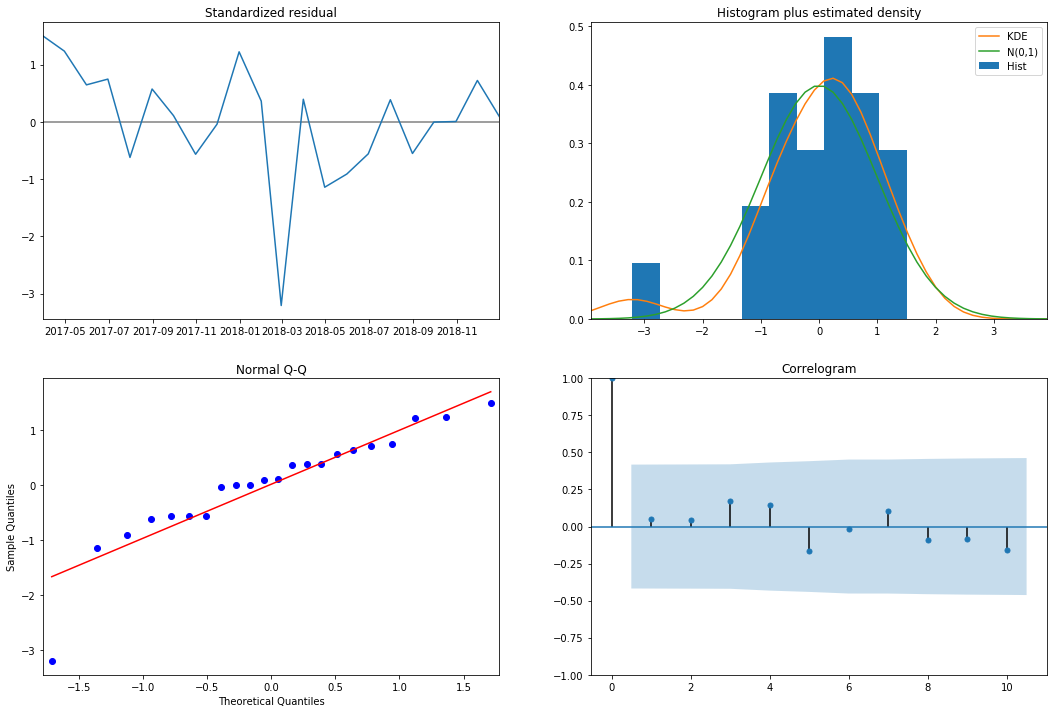

In [48]:
osARIMA = SARIMAX(dfsDict_M_Train['OS'], order=(0,2,2), seasonal_order=(0,1,0,12)).fit(disp=0)
print(osARIMA.summary())
osARIMA.plot_diagnostics(figsize = (18,12))
osPREDICTIONS = osARIMA.predict()
osFORECAST = osARIMA.forecast(steps = 24)

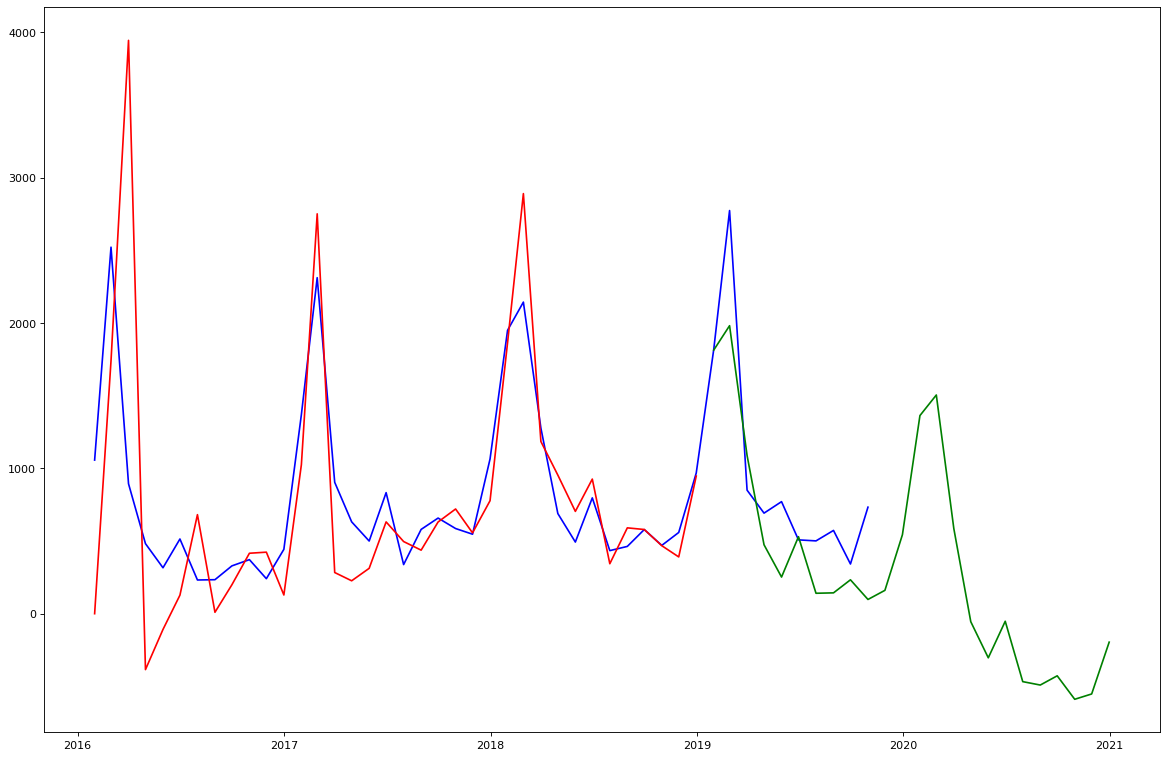

In [49]:
figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfsDict_M_TrainTest['OS'].x, color = 'b')
plt.plot(osPREDICTIONS, color = 'r')
plt.plot(osFORECAST, color = 'g')

In [50]:
print('MSE Training: ', mean_squared_error(dfsDict_M_Train['OS'].x, osPREDICTIONS))
print('MSE Test: ', mean_squared_error(dfsDict_M_Test['OS'].x, osFORECAST[0:10]))

MSE Training:  398971.4048434433
MSE Test:  173108.89636841114


[0,              PDV
 datum           
 2016-01-31  1962
 2016-02-29  1535
 2016-03-31   933
 2016-04-30  1146
 2016-05-31  1078
 2016-06-30   918
 2016-07-31   625
 2016-08-31   669
 2016-09-30   633
 2016-10-31   914
 2016-11-30   601
 2016-12-31   847
 2017-01-31  1298
 2017-02-28  1334
 2017-03-31   848
 2017-04-30  1123
 2017-05-31  1034
 2017-06-30   892
 2017-07-31   864
 2017-08-31  1200
 2017-09-30  1230
 2017-10-31  1105
 2017-11-30  1383
 2017-12-31  1563
 2018-01-31  2527
 2018-02-28  1885
 2018-03-31  1642
 2018-04-30  1310
 2018-05-31  1018
 2018-06-30  1322
 2018-07-31  6064
 2018-08-31  8998
 2018-09-30  3812
 2018-10-31  4171
 2018-11-30  2894
 2018-12-31  2957, <Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>]

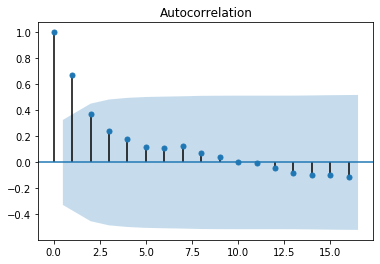

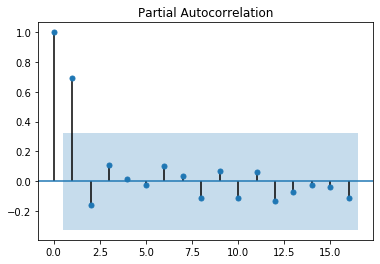

In [51]:
arimaDiag('PDV')

D:\Python_Sve\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                 Statespace Model Results                                 
Dep. Variable:                                  x   No. Observations:                   36
Model:             SARIMAX(0, 0, 2)x(0, 1, 0, 12)   Log Likelihood                -188.685
Date:                            Tue, 10 Dec 2019   AIC                            383.370
Time:                                    23:10:42   BIC                            386.904
Sample:                                01-31-2016   HQIC                           384.307
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0686      0.194      5.498      0.000       0.688       1.450
ma.L2          0.6045      0.183   

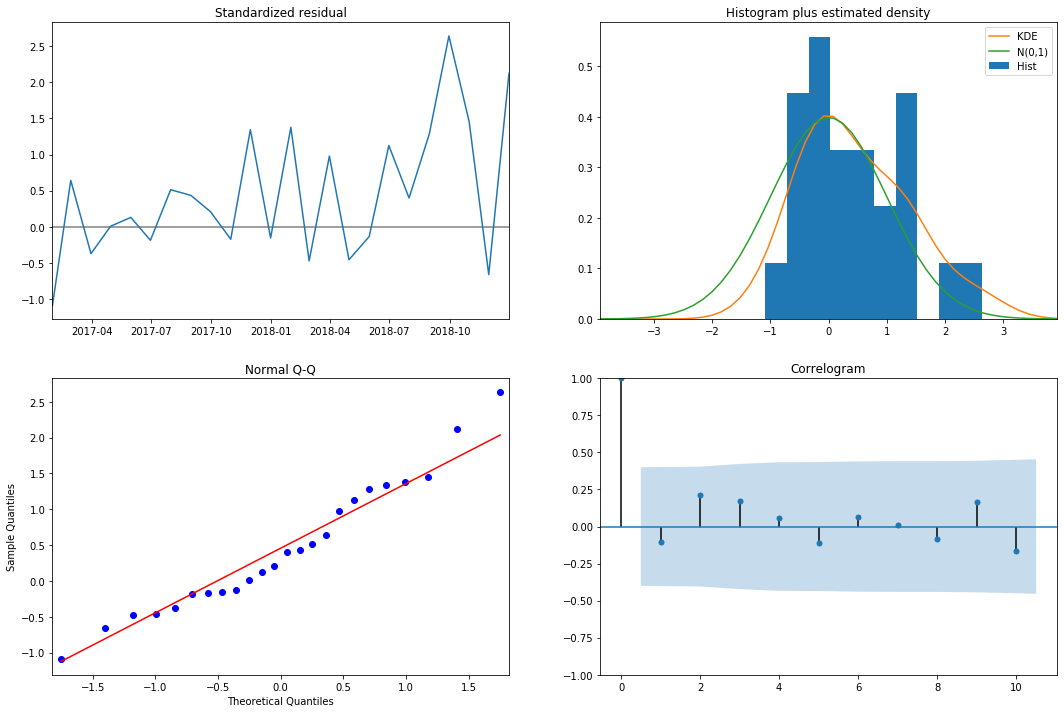

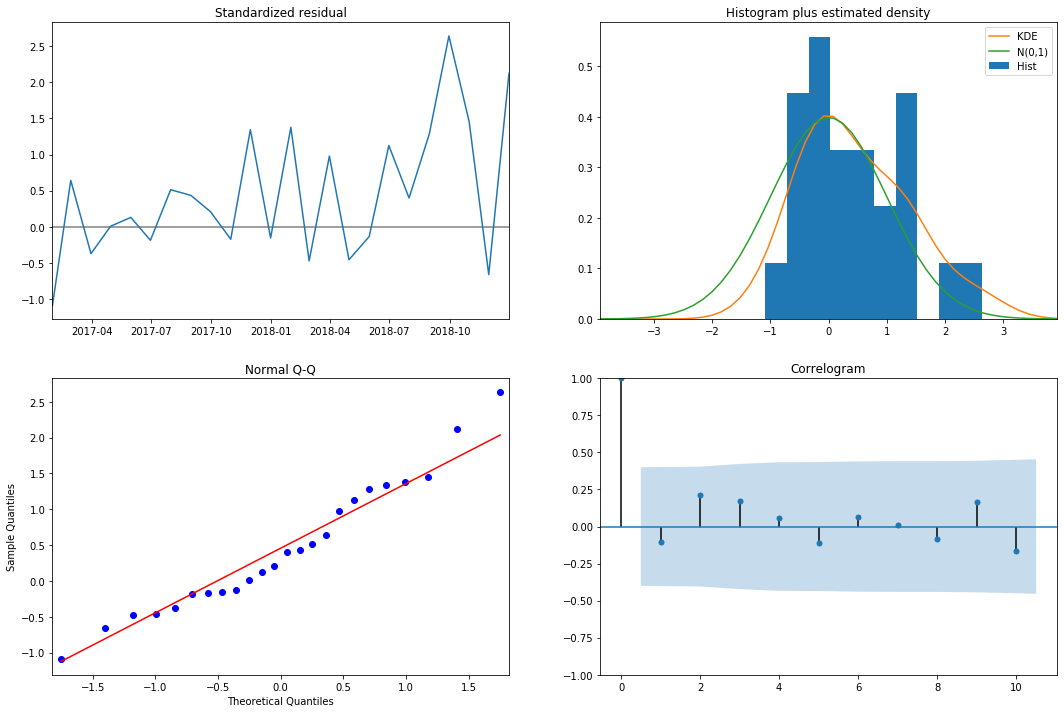

In [52]:
def mean(lst):
    return sum(lst)/len(lst)

pdvMEAN = mean(list(dfsDict_M_Train['PDV'].x))
dfPDV = dfsDict_M_Train['PDV']
dfPDV = dfPDV.replace(to_replace = 6064, value = pdvMEAN)
dfPDV = dfPDV.replace(to_replace = 8998, value = pdvMEAN*(8998/6064))


pdvARIMA = SARIMAX(dfPDV, order=(0,0,2),seasonal_order=(0,1,0,12)).fit(disp=0)
print(pdvARIMA.summary())
pdvARIMA.plot_diagnostics(figsize = (18,12))

In [53]:
pdvPREDICTIONS = pdvARIMA.predict()
pdvFORECAST = pdvARIMA.forecast(steps = 24)

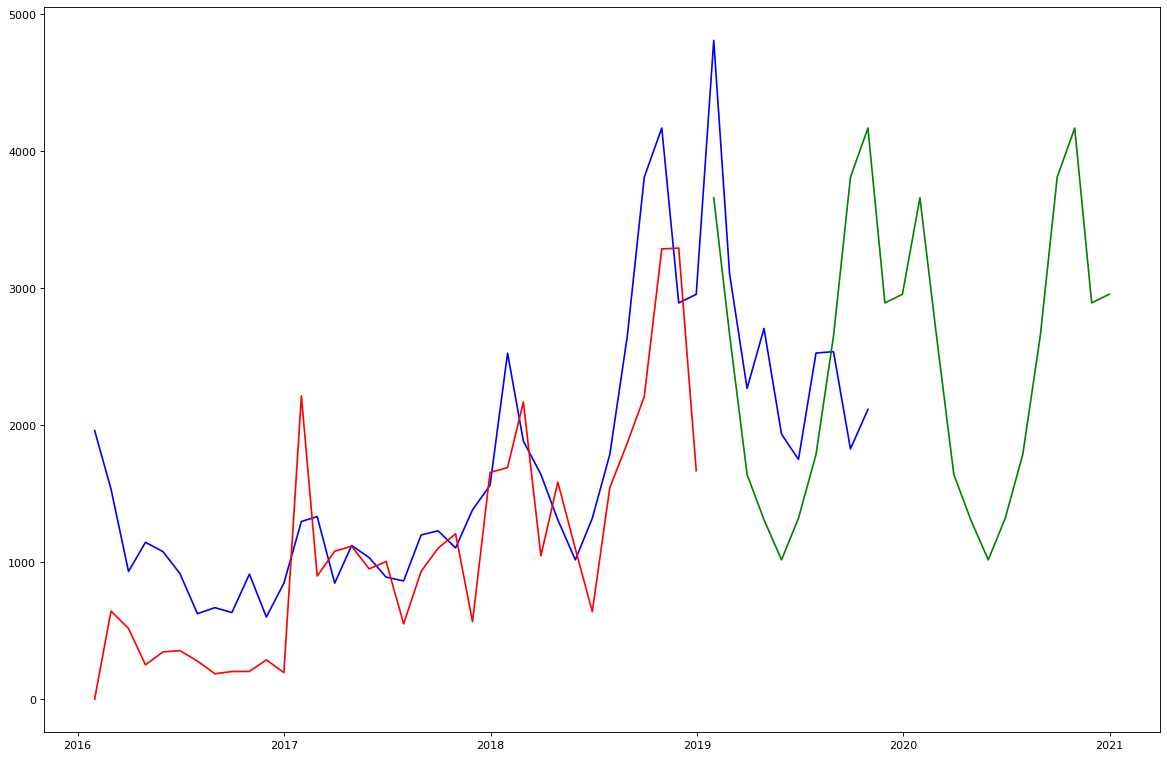

In [54]:
figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pd.concat([dfPDV, dfsDict_M_Test['PDV']]), color = 'b')
plt.plot(pdvPREDICTIONS, color = 'r')
plt.plot(pdvFORECAST, color = 'g')

In [55]:
print('MSE Training: ', mean_squared_error(dfPDV.x, pdvPREDICTIONS))
print('MSE Test :', mean_squared_error(dfsDict_M_Test['PDV'].x, pdvFORECAST[0:10]))

MSE Training:  486864.049311261
MSE Test : 1360700.7789359994


[0,              PRO
 datum           
 2016-01-31   398
 2016-02-29   354
 2016-03-31   177
 2016-04-30   374
 2016-05-31   236
 2016-06-30    71
 2016-07-31   125
 2016-08-31    69
 2016-09-30    46
 2016-10-31   126
 2016-11-30   362
 2016-12-31   155
 2017-01-31   379
 2017-02-28   607
 2017-03-31   460
 2017-04-30   255
 2017-05-31   183
 2017-06-30   337
 2017-07-31    85
 2017-08-31   174
 2017-09-30   133
 2017-10-31   251
 2017-11-30   368
 2017-12-31   619
 2018-01-31  1036
 2018-02-28   974
 2018-03-31   373
 2018-04-30   577
 2018-05-31   562
 2018-06-30   438
 2018-07-31   321
 2018-08-31   144
 2018-09-30   161
 2018-10-31   287
 2018-11-30   170
 2018-12-31   222, <Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>]

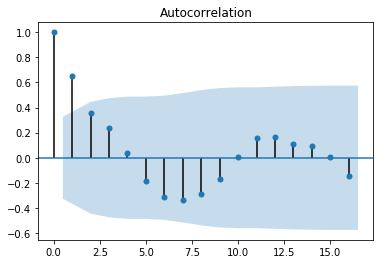

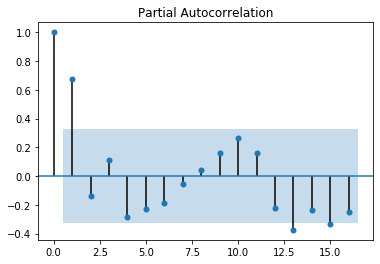

In [56]:
arimaDiag('PRO')

                                 Statespace Model Results                                
Dep. Variable:                                 x   No. Observations:                   36
Model:             SARIMAX(0, 0, 1)x(1, 1, 0, 6)   Log Likelihood                -203.825
Date:                           Tue, 10 Dec 2019   AIC                            413.649
Time:                                   23:10:47   BIC                            417.853
Sample:                               01-31-2016   HQIC                           414.994
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6114      0.197      3.105      0.002       0.225       0.997
ar.S.L6       -0.7305      0.207     -3.529

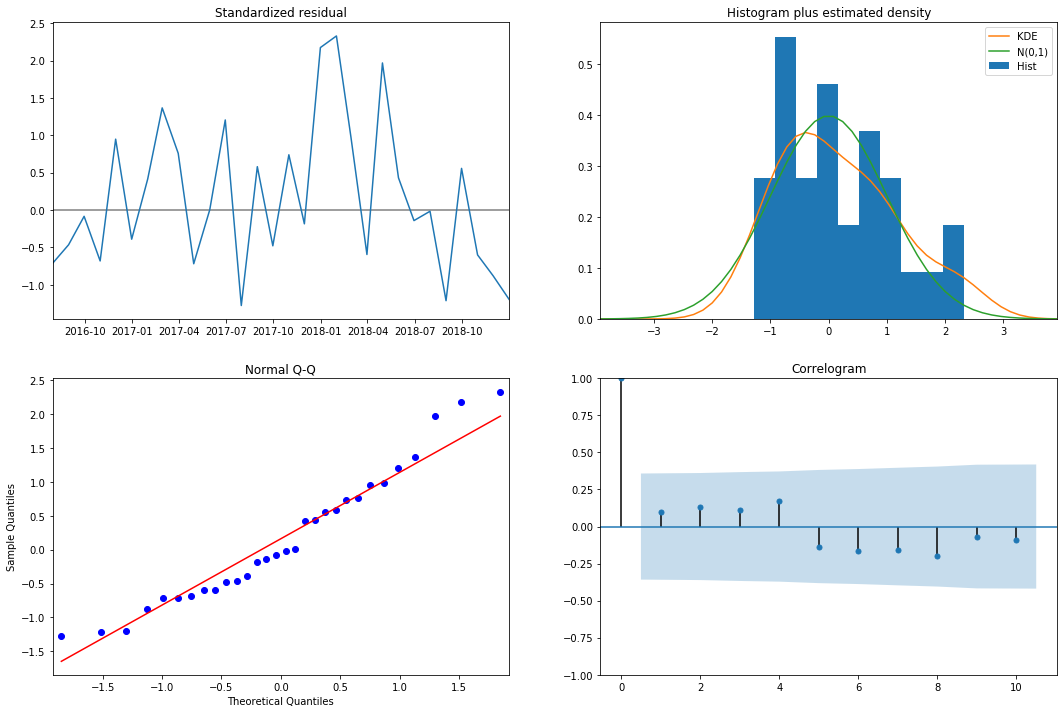

In [57]:
proARIMA = SARIMAX(dfsDict_M_Train['PRO'], order = (0,0,1), seasonal_order=(1,1,0,6)).fit(disp=0)
print(proARIMA.summary())
proARIMA.plot_diagnostics(figsize = (18,12))
proPREDICTIONS = proARIMA.predict()
proFORECAST = proARIMA.forecast(steps = 24)


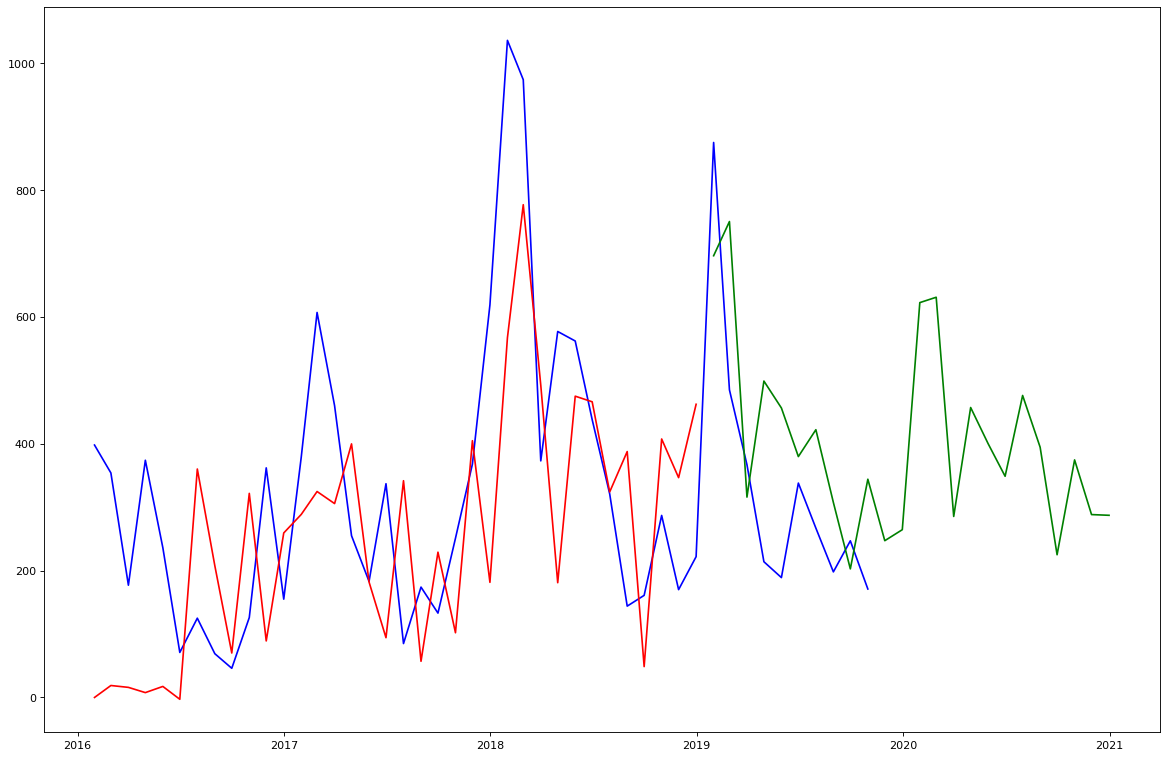

In [58]:
figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfsDict_M_TrainTest['PRO'].x, color = 'b')
plt.plot(proPREDICTIONS, color = 'r')
plt.plot(proFORECAST, color = 'g')

In [59]:
print('MSE Training: ', mean_squared_error(dfsDict_M_Train['PRO'].x, proPREDICTIONS ))
print('MSE Test: ', mean_squared_error(dfsDict_M_Test['PRO'].x, proFORECAST[0:10]))

MSE Training:  49771.66969704753
MSE Test:  32725.10833943998


In [60]:
#That concludes ARIMA modeling for all 10 modules. 'KASA' and 'FIN' modules forecasts show,
#for example, that looking at the past is enough to know the future, with minor difference in the level. 

#Module with the most interesting forecast is 'PDV', it predicts slow steady growth in 2020 with shorter seasonal intervals. I know
#for a fact that that is due to tax law changes, so the model captured that and the forecast showed what it showed. Looking at 
#the MSEs on training and test once could spott overfitting, but 'PDV' is a series that is expected to change it's course in the
#years to come and that's why I left the model with MSE greater on test than on training. 
#Module 'KASA' has a forecast that shows sliht downward trend in next year, aswell as 'FIN', except 'FIN' keeps its seasonality
#on a sligthly lower level.
#As for other modules, their forecasts are pretty much 'pictures in the mirror' of previous years.

#What we've learned:
# Overall dynamics of modules
# How they're likely to behave in the year 2020
# No significant cointegration between pair of modules that were candidates for it
# based on forecasts for 2020, we can classify each module in one of 3 categories: growing, falling and noChange, pretty self-explanatory



#Turned out that I didn't even use weakly data for anything but the module 'TEHNICKA' (below), because during my time working on this project I came up with
#a next step.

#Next step in this project is to analyze time
#series data on a daily level separated by employees, and for that I'm going to use Reccurent Neural Network with LSTMs and, 
#data is going to be daily, and forecast horizon will be much smaller. Another goal is to see which employees mostly deal 
#with which module (specifically using K-Means cluster analysis, as requested by the client - it will be explained in the code) 
#so the client can rearrange his employees on modules accordingly. Secand major phase of this project 
#is a software that runs LSTM in real time for a given
#time series dataset. Code will be provided aswell when finished.



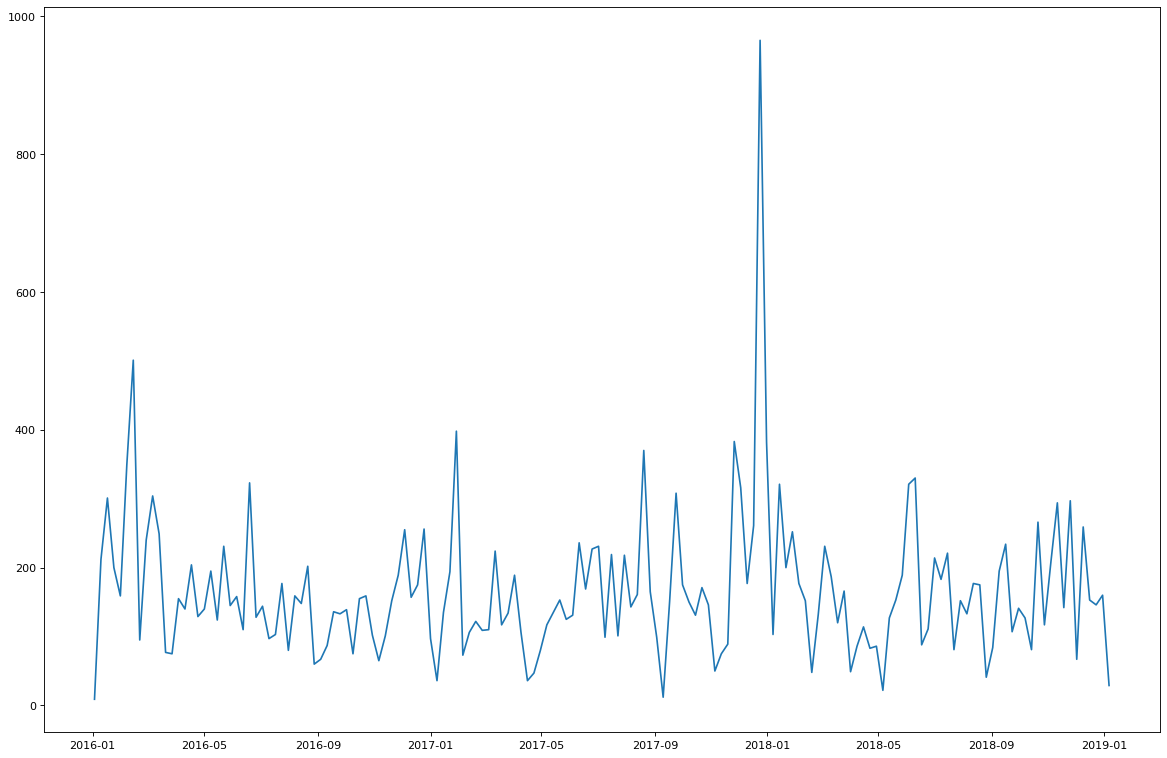

In [61]:
#Additional analysis - module 'TEHNICKA'
#I'm going to try to fit a better ARIMA on tehnicka segment with weekly data instead of monthly. At the time I'm writing this
#I got a request from the client to do detailed analysis of this module, and I'm going to start with this.
figure(num=None, figsize=(18, 12), dpi=80)
plt.plot(dfsDict_W_Train['TEHNICKA'])
plt.show()



In [62]:
trendW = []
for i in range(1, 159):
    trendW.append(i)



In [63]:
SWregTeh = smapi.OLS(dfsDict_W_Train['TEHNICKA'].x, trendW).fit()
SWregTeh.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      x   R-squared (uncentered):                   0.538
Model:                            OLS   Adj. R-squared (uncentered):              0.535
Method:                 Least Squares   F-statistic:                              183.0
Date:                Tue, 10 Dec 2019   Prob (F-statistic):                    3.95e-28
Time:                        23:10:49   Log-Likelihood:                         -997.62
No. Observations:                 158   AIC:                                      1997.
Df Residuals:                     157   BIC:                                      2000.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.5740      0.116     13.526      0.000       1.344       1.804
==============================================================================
Omnibus:                       77.426   Durbin-Watson:                   0.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              446.048
Skew:                           1.693   Prob(JB):                     1.39e-97
Kurtosis:                      10.503   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
adfTehW = adfuller(dfsDict_W_Train['TEHNICKA'].x, maxlag=10, regression='ct')
print(adfTehW)

(-9.700712357412053, 1.0118526777931601e-14, 0, 157, {'1%': -4.0176210361655995, '5%': -3.438832642961963, '10%': -3.1436838085833383}, 1773.250815001278)


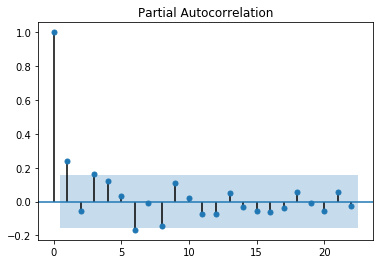

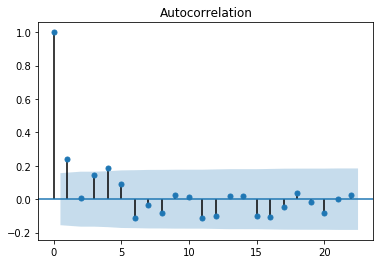

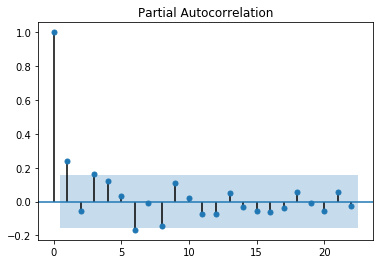

In [65]:
plot_acf(dfsDict_W_Train['TEHNICKA'])
plot_pacf(dfsDict_W_Train['TEHNICKA'])

                                 Statespace Model Results                                 
Dep. Variable:                                  x   No. Observations:                  158
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -906.279
Date:                            Tue, 10 Dec 2019   AIC                           1820.557
Time:                                    23:10:52   BIC                           1832.492
Sample:                                01-03-2016   HQIC                          1825.406
                                     - 01-06-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2639      0.121      2.181      0.029       0.027       0.501
ar.S.L12      -0.7176      0.057   

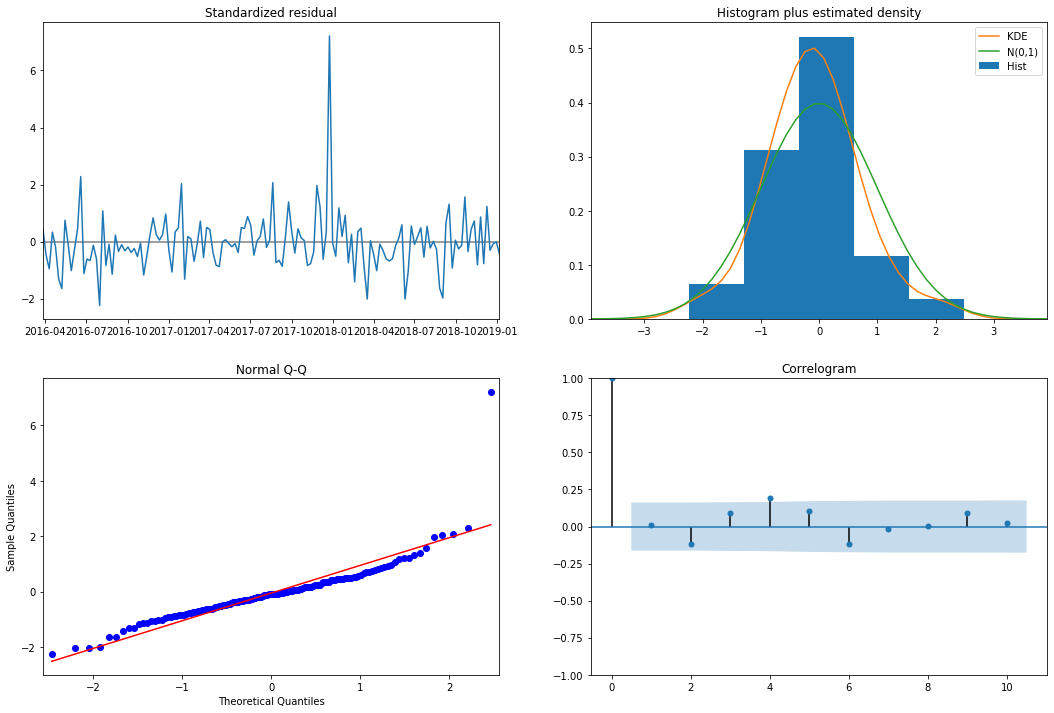

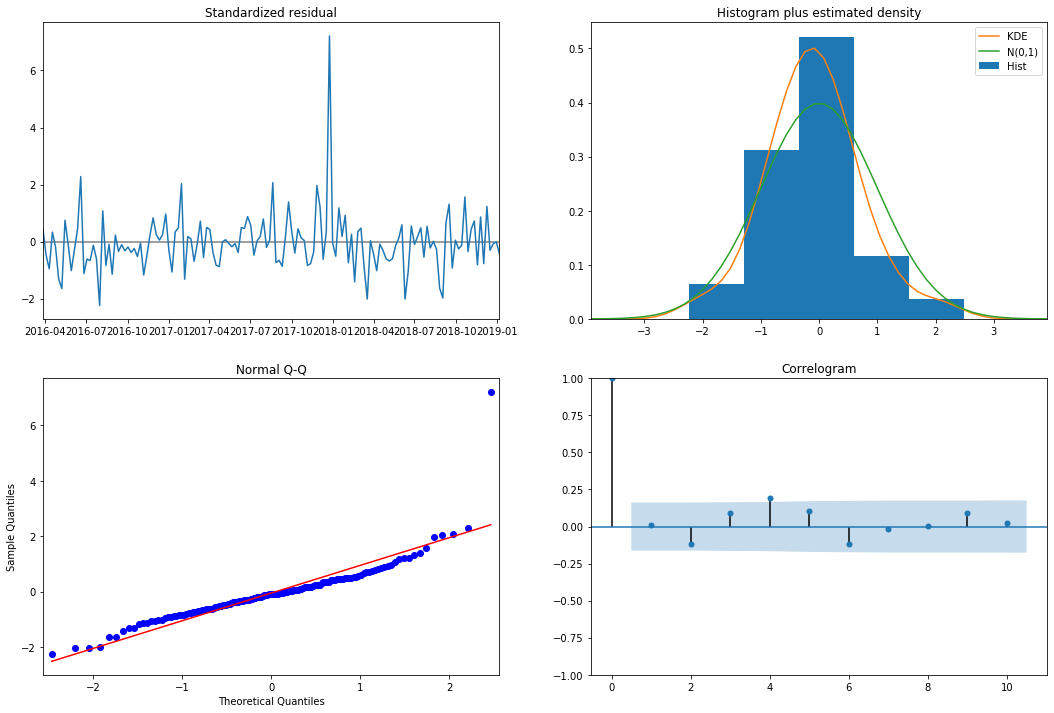

In [66]:
tehWARIMA = SARIMAX(dfsDict_W_Train['TEHNICKA'], order=(1,0,0), seasonal_order=(2,1,0,12)).fit(disp=0)
print(tehWARIMA.summary())
tehWARIMA.plot_diagnostics(figsize = (18,12))

In [67]:
tehPREDICTIONS = tehWARIMA.predict()
tehFORECAST = tehWARIMA.forecast(steps = 2*len(dfsDict_W_Test['TEHNICKA']))

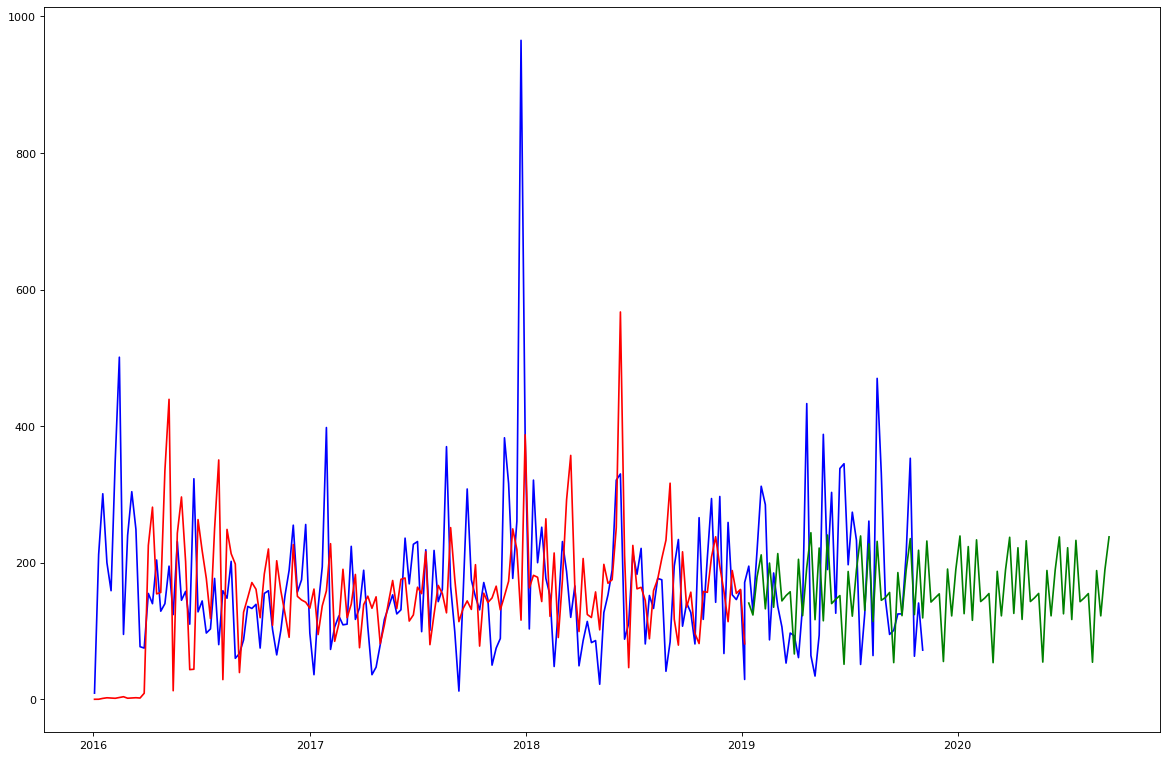

In [68]:
figure(num=None, figsize=(18, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(dfsDict_W_TrainTest['TEHNICKA'].x, color = 'b')
plt.plot(tehPREDICTIONS, color = 'r')
plt.plot(tehFORECAST, color = 'g')
plt.show()